# Demo: Streamlined Clock Offset Analysis

This notebook provides a streamlined version of clock offset analysis for oceanographic instruments.
It uses the new `oceanarray.clock_offset` module for cleaner, more maintainable code.

## Purpose

This notebook helps determine whether instrument timestamps are incorrect by:
1. Analyzing deployment timing based on temperature profiles
2. Performing lag correlation analysis between instruments
3. Calculating recommended clock offset corrections

**Note:** This notebook does not modify data files. It only analyzes and suggests clock_offset values for the YAML configuration.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from oceanarray import clock_offset

## Configuration

In [2]:
# Configuration
mooring_name = 'dsE_1_2018'
base_dir = '/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/'
output_path = base_dir + 'moor/proc/'

# Choose file type: '_raw' for original data, '_use' for processed data
file_suffix = '_raw'
# file_suffix = '_use'

print(f"Analyzing mooring: {mooring_name}")
print(f"Using files with suffix: {file_suffix}")

Analyzing mooring: dsE_1_2018
Using files with suffix: _raw


## Load and Process Data

In [3]:
# Load instrument data
datasets, moor_yaml_data = clock_offset.load_mooring_instruments(
    mooring_name, base_dir, output_path, file_suffix
)

print(f"Loaded {len(datasets)} instruments")

/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6363_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe16/dsE_1_2018_2419_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6401_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6402_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_8482_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6365_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6409_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6397_raw.nc
/Users/eddifying/Dropbox/data/ifmro_mixsed/ds_data_eleanor/moor/proc/dsE_1_2018/sbe56/dsE_1_2018_6366_raw.nc
/Users/eddifying/Dr

/Users/eddifying/Cloudfree/github/oceanarray/oceanarray/clock_offset.py:52: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds1 = xr.open_dataset(rawfile)


In [4]:
# Create common time grid and interpolate
time_grid = clock_offset.create_common_time_grid(datasets)
datasets_interp = clock_offset.interpolate_datasets_to_grid(datasets, time_grid)

# Combine into single multi-level dataset
combined_ds = clock_offset.combine_interpolated_datasets(datasets_interp)

print(f"Combined dataset shape: {combined_ds.dims}")
print(f"Time grid length: {len(time_grid)}")
print(f"Time range: {time_grid[0]} to {time_grid[-1]}")

Combined dataset shape: FrozenMappingWarningOnValuesAccess({'time': 134395, 'N_LEVELS': 22})
Time grid length: 134395
Time range: 2018-08-12T12:00:00.000000000 to 2018-08-28T01:19:00.000000000


## Deployment Timing Analysis

In [5]:
# Analyze deployment timing using temperature profiles
combined_ds = clock_offset.analyze_deployment_timing(combined_ds)

print("Deployment timing analysis completed")
print(f"Dataset now includes: {list(combined_ds.data_vars)}")

My time starts at 2018-08-12T12:00:00.000000000
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000000
My sea_mean is 5.28304850628991 and std is 3.904941372465599
0/6363:sbe56: Split at 11.14.  Start after 2018-08-13T21:03:40.000000000.  End with 2018-08-27T11:34:00.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000000
My sea_mean is 4.132818607619568 and std is 2.1875122354977545
1/2419:sbe16: Split at 7.41.  Start after 2018-08-12T22:46:00.000000000.  End with 2018-08-24T11:02:40.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000

/Users/eddifying/Cloudfree/github/oceanarray/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


3/6402:sbe56: Split at 10.93.  Start after 2018-08-13T22:04:00.000000000.  End with 2018-08-27T11:32:40.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000000
My sea_mean is 5.51091430100573 and std is 5.492666524620486
4/8482:sbe56: Split at 13.75.  Start after 2018-08-13T19:56:00.000000000.  End with 2018-08-27T11:42:50.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000000
My sea_mean is 4.465314095931694 and std is 4.14750212495294
5/6365:sbe56: Split at 10.69.  Start after 2018-08-13T21:50:20.000000000.  End with 2018-08-27T11:33:30.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-

/Users/eddifying/Cloudfree/github/oceanarray/venv/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:1409: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


15/13874:tr1050: Split at 9.76.  Start after 2018-08-12T16:24:30.000000000.  End with 2018-08-22T19:10:20.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000000
My sea_mean is 3.8494040961385685 and std is 5.682950868939585
16/101645:rbrsolo: Split at 12.37.  Start after 2018-08-12T21:19:20.000000000.  End with 2018-08-26T11:38:50.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_start is 2018-08-12T14:00:00.000000000 and bot_end is 2018-08-27T23:19:00.000000000
My sea_mean is 3.708464588210509 and std is 5.683451500615129
17/15574:tr1050: Split at 12.23.  Start after 2018-08-12T21:28:00.000000000.  End with 2018-08-26T11:39:30.000000000.
recovery time is 2018-08-28T01:19:00.000000000
My start is 2018-08-12 12:00:00 and end is 2018-08-28 01:19:00
My bot_s

## Visualize Temperature Profiles

/var/folders/t1/z5bp59k95119nw35yqv699t40000gn/T/ipykernel_78656/60325025.py:9: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for i in range(combined_ds.dims["N_LEVELS"]):


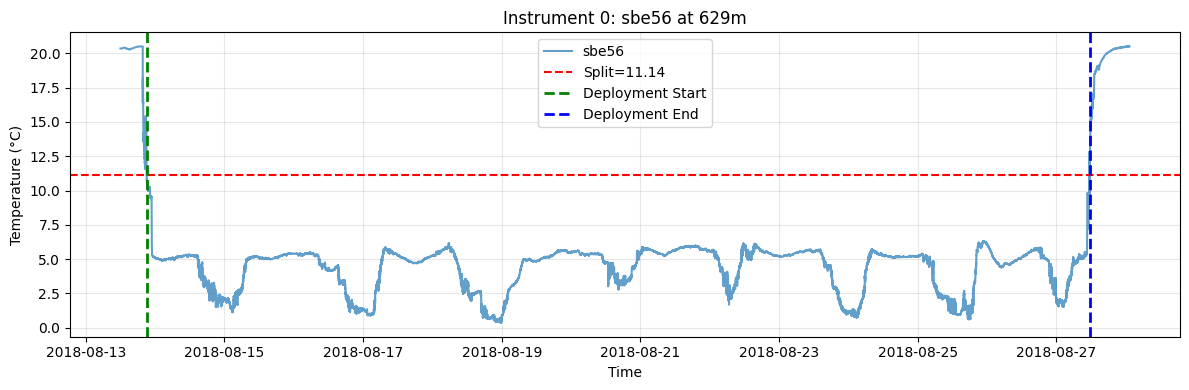

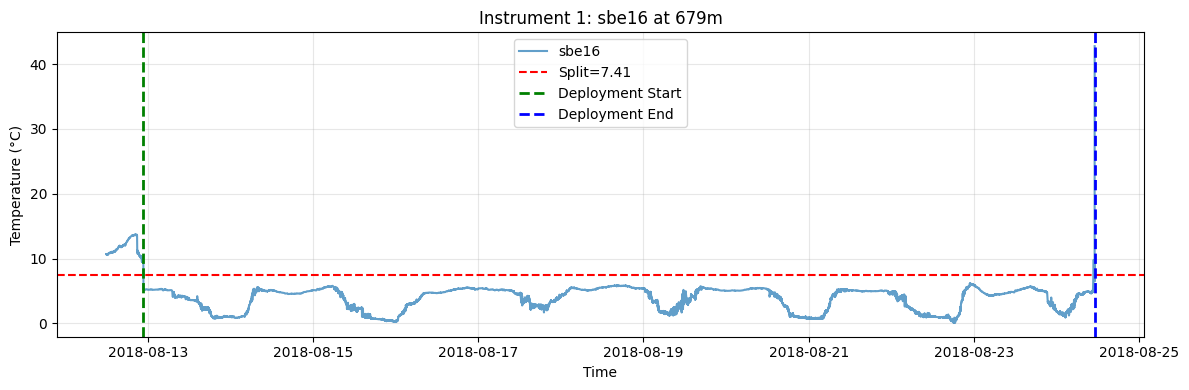

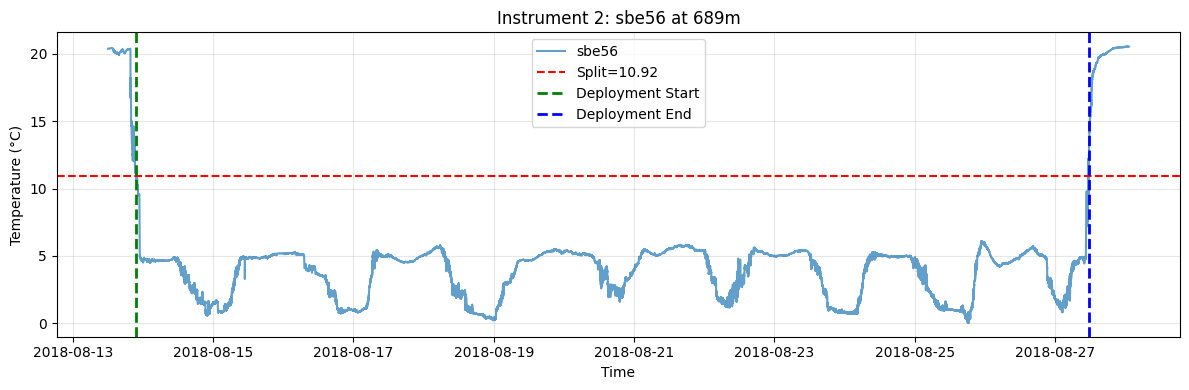

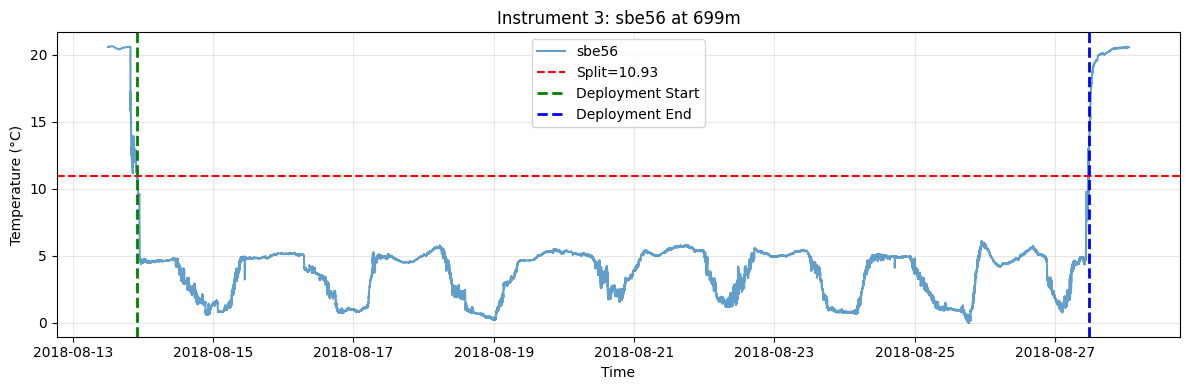

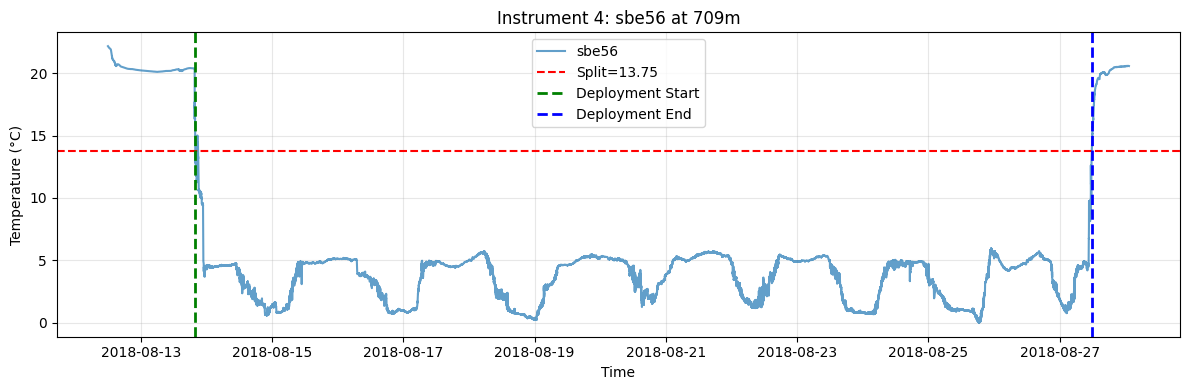

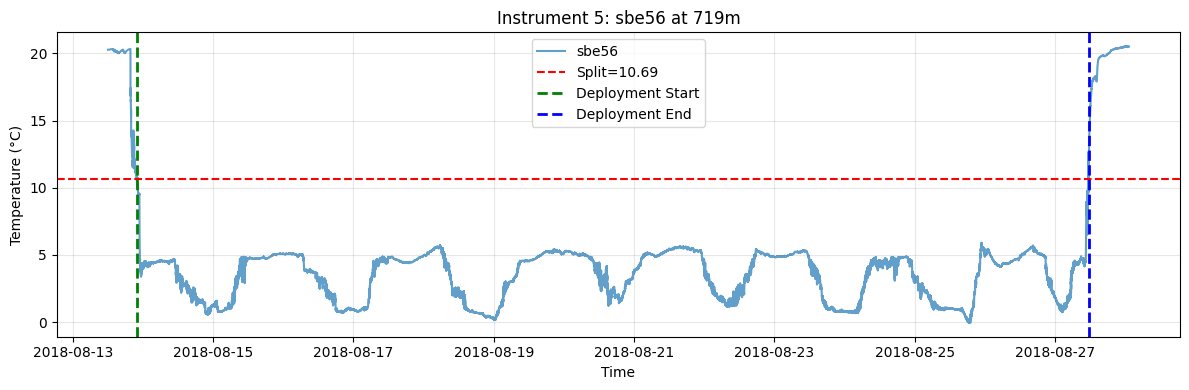

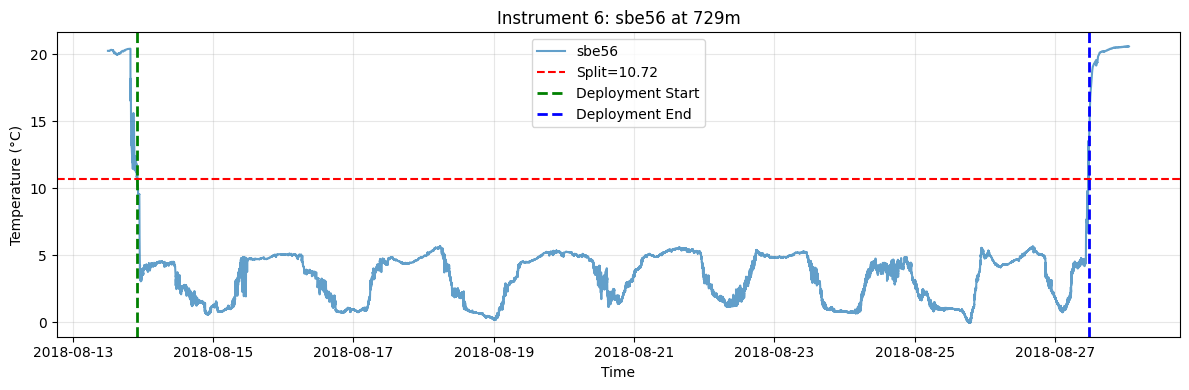

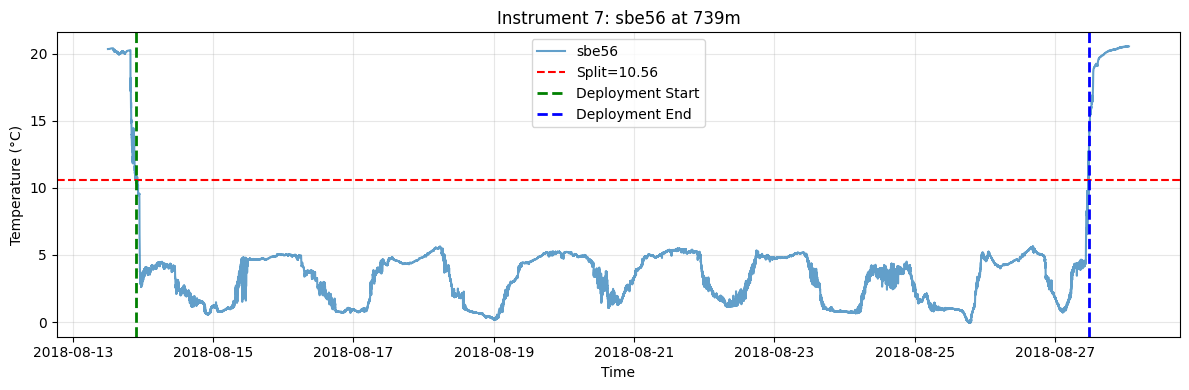

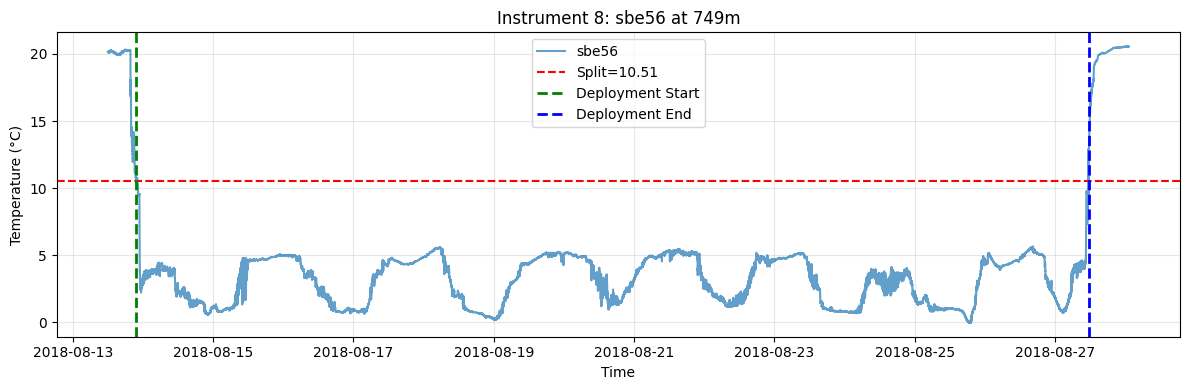

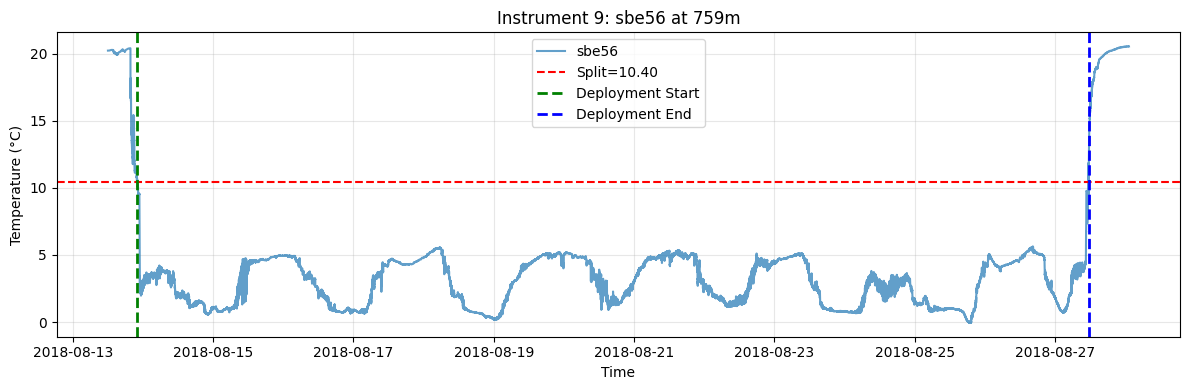

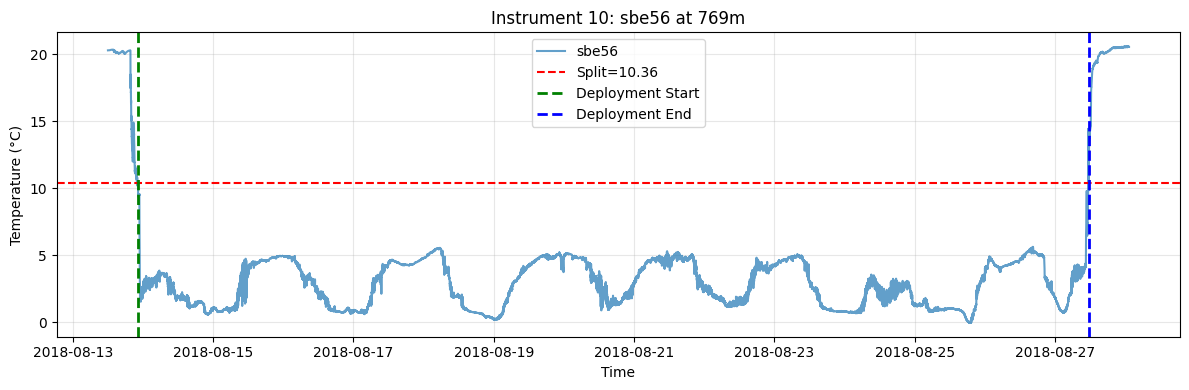

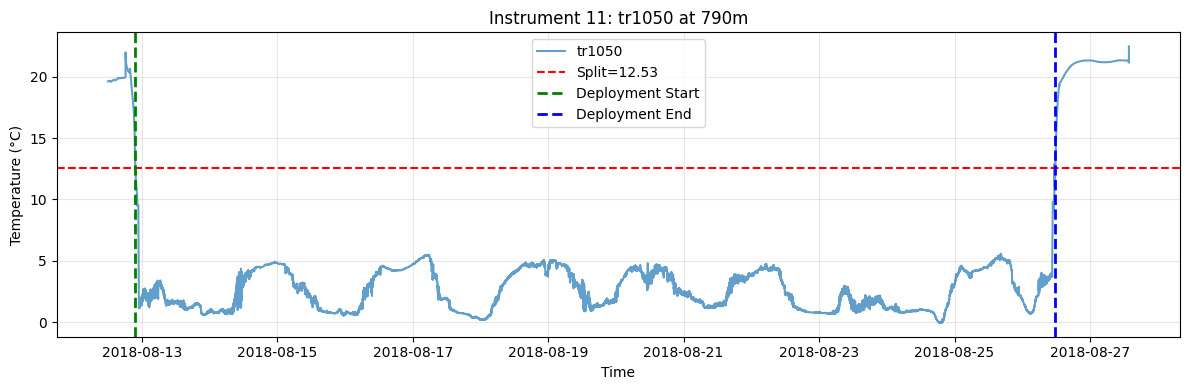

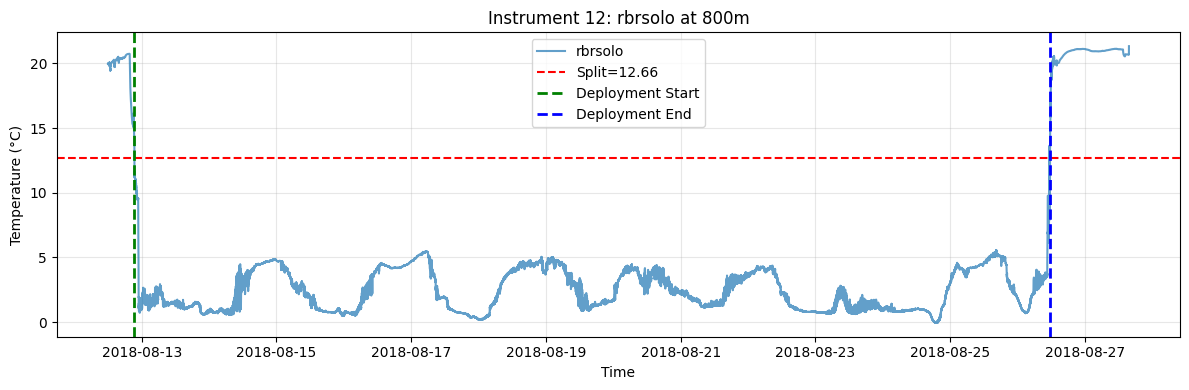

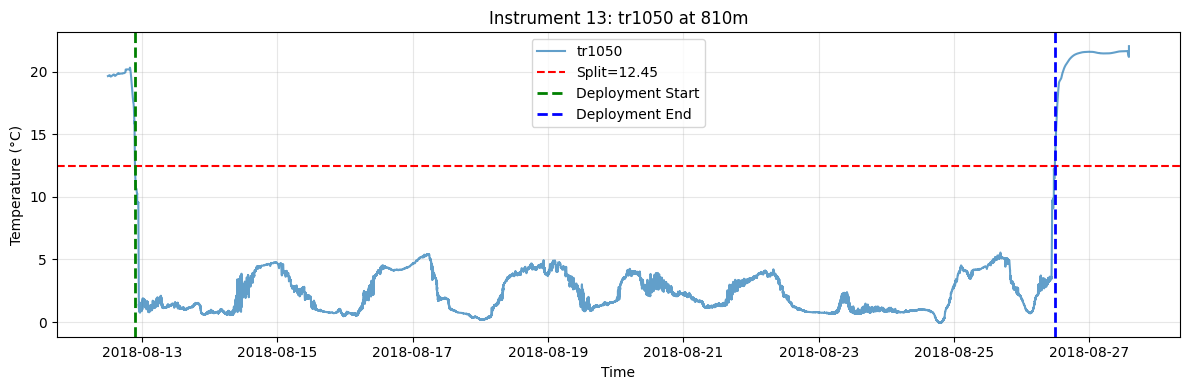

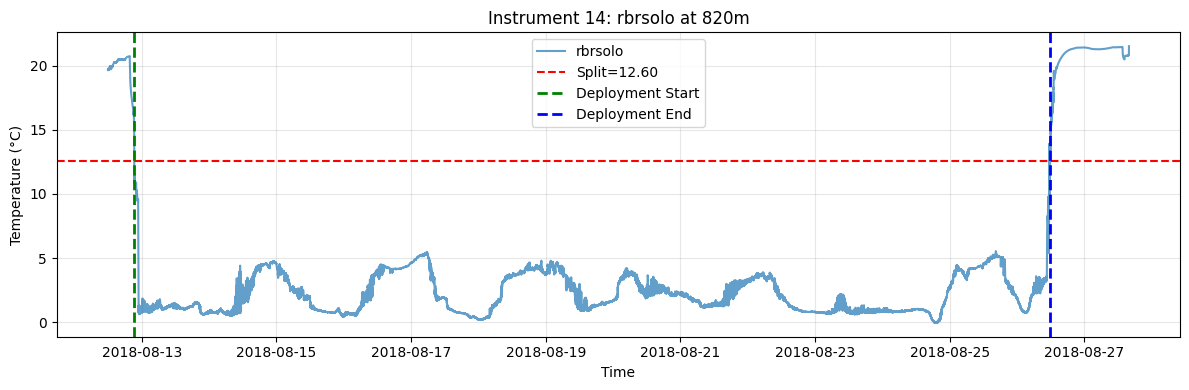

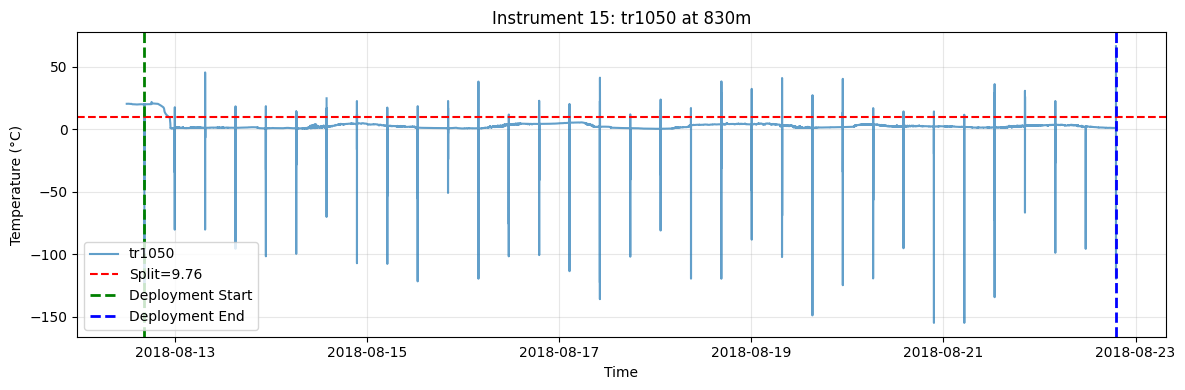

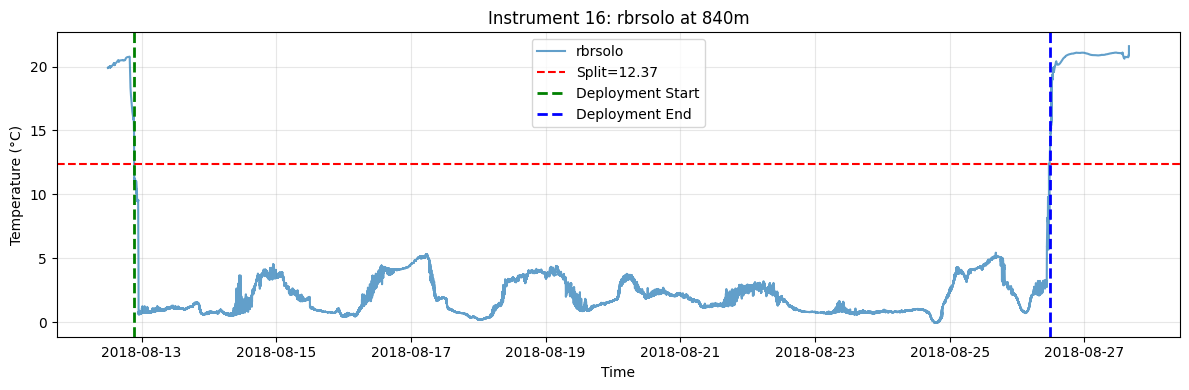

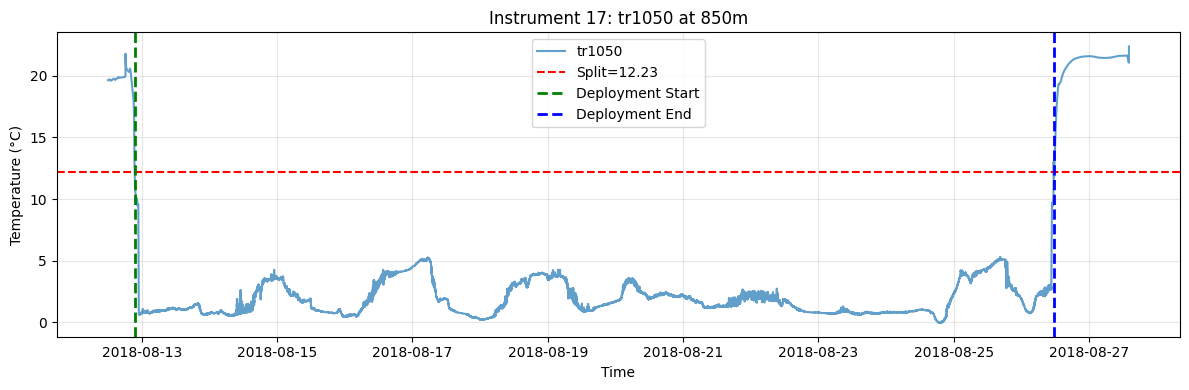

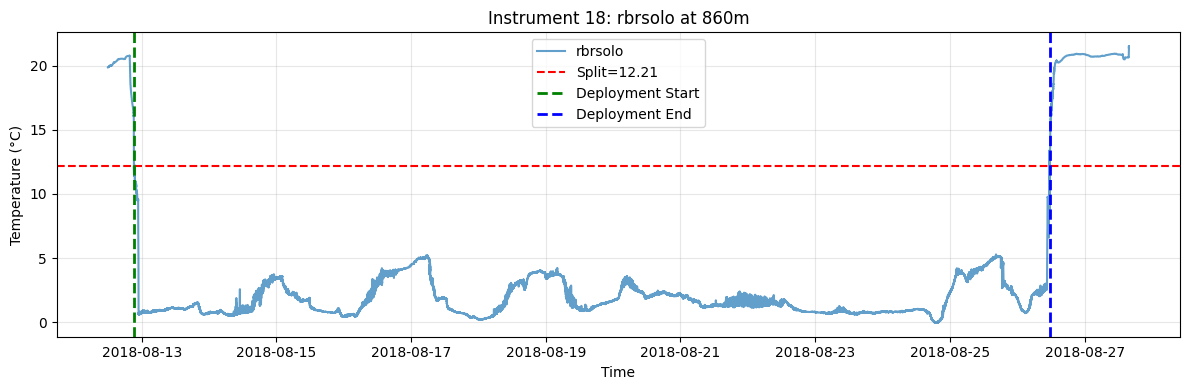

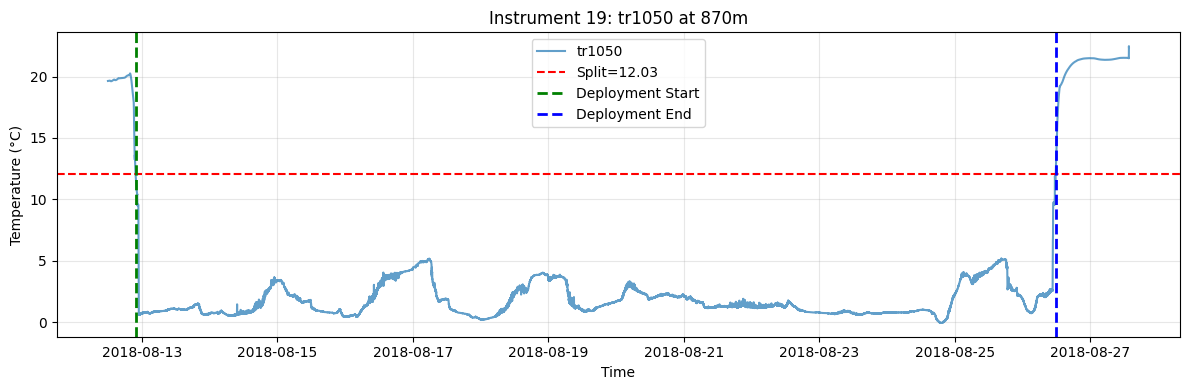

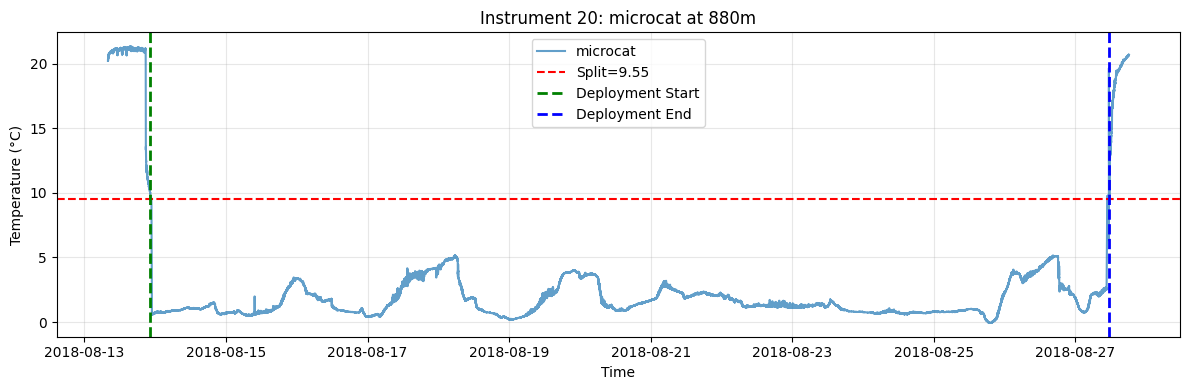

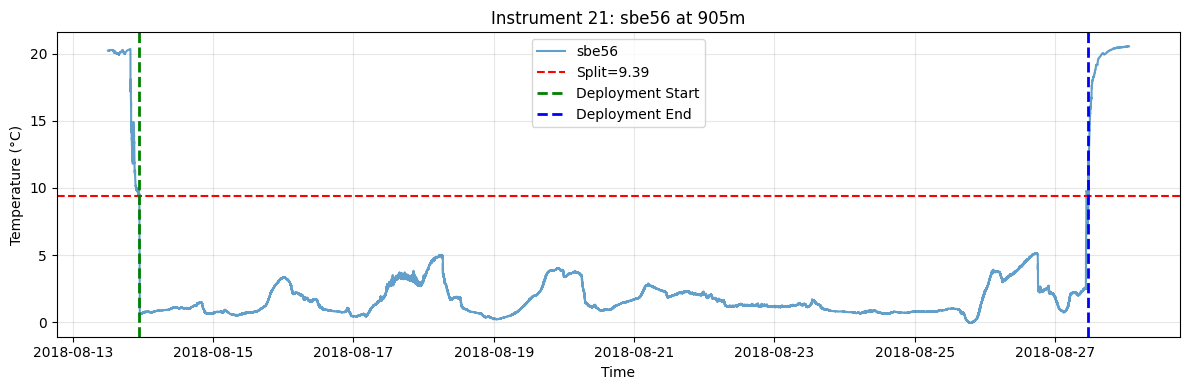

In [6]:
# Plot temperature time series with deployment bounds
time = combined_ds["time"].values
temp = combined_ds["temperature"].values
split_vals = combined_ds["split_value"].values
instruments = combined_ds["instrument"].values
start_times = combined_ds["start_time"].values
end_times = combined_ds["end_time"].values

for i in range(combined_ds.dims["N_LEVELS"]):
    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(time, temp[:, i], label=f"{instruments[i]}", alpha=0.7)
    ax.axhline(split_vals[i], color="red", linestyle="--",
               label=f"Split={split_vals[i]:.2f}")

    # Plot deployment bounds if available
    if np.isfinite(start_times[i].astype("datetime64[ns]").astype("int64")):
        ax.axvline(start_times[i], color="green", linestyle="--", lw=2,
                   label="Deployment Start")
    if np.isfinite(end_times[i].astype("datetime64[ns]").astype("int64")):
        ax.axvline(end_times[i], color="blue", linestyle="--", lw=2,
                   label="Deployment End")

    ax.set_title(f"Instrument {i}: {instruments[i]} at {combined_ds['nominal_depth'][i].values:.0f}m")
    ax.set_xlabel("Time")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## Calculate Timing Offsets

In [7]:
# Calculate timing offsets based on deployment bounds
offset_results = clock_offset.calculate_timing_offsets(combined_ds)

# Print summary table
clock_offset.print_timing_offset_summary(combined_ds, offset_results)

Consensus group size: 1
Consensus-derived refs -> ref_start=2018-08-12 16:24:30, ref_end=2018-08-22 19:10:20

00: sbe56   /6363   | start=2018-08-13 21:03:40 ( +103150s) | end=2018-08-27 11:34:00 ( +404620s) | avg= +253885s | diff=-301470s | drift=+22159.75 s/day | -
01: sbe16   /2419   | start=2018-08-12 22:46:00 (  +22890s) | end=2018-08-24 11:02:40 ( +143540s) | avg=  +83215s | diff=-120650s | drift=+10480.76 s/day | -
02: sbe56   /6401   | start=2018-08-13 21:43:40 ( +105550s) | end=2018-08-27 11:33:40 ( +404600s) | avg= +255075s | diff=-299050s | drift=+22027.21 s/day | -
03: sbe56   /6402   | start=2018-08-13 22:04:00 ( +106770s) | end=2018-08-27 11:32:40 ( +404540s) | avg= +255655s | diff=-297770s | drift=+21956.89 s/day | -
04: sbe56   /8482   | start=2018-08-13 19:56:00 (  +99090s) | end=2018-08-27 11:42:50 ( +405150s) | avg= +252120s | diff=-306060s | drift=+22409.63 s/day | -
05: sbe56   /6365   | start=2018-08-13 21:50:20 ( +105950s) | end=2018-08-27 11:33:30 ( +404590s) | 

## Detailed Deployment Boundary Visualization

Examine the exact transition points with individual measurements around predicted deployment boundaries.

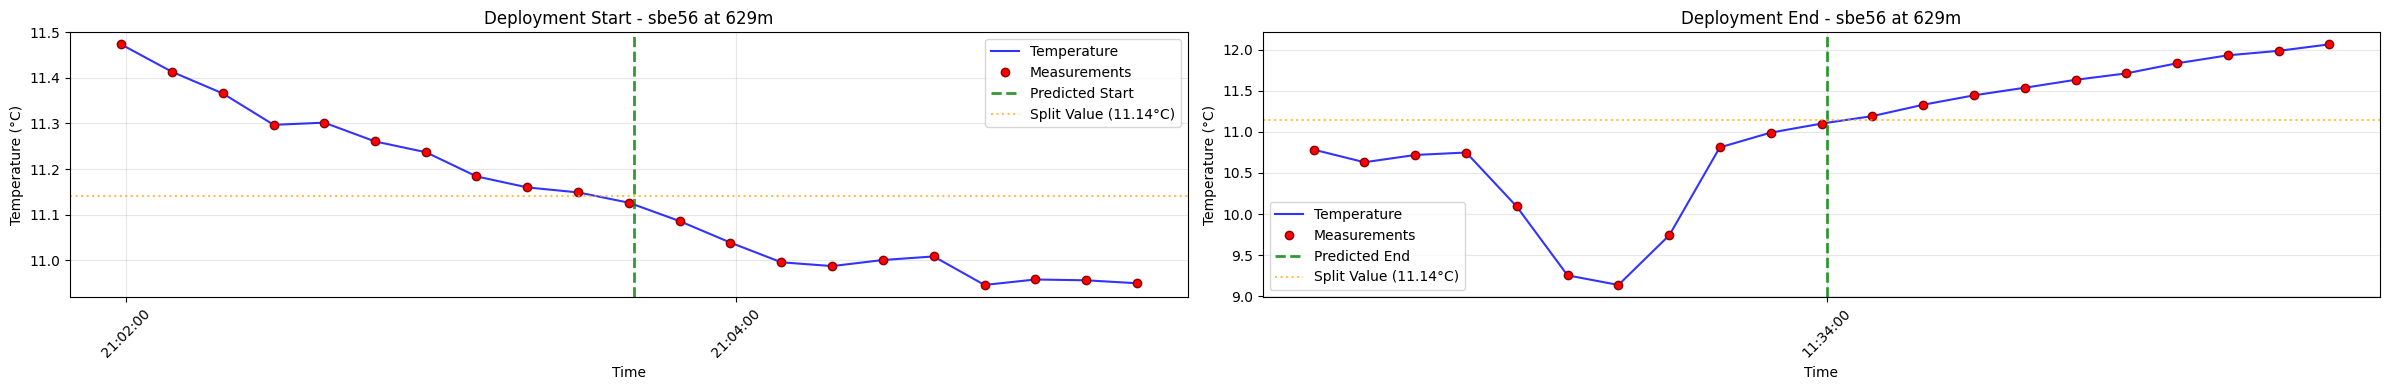

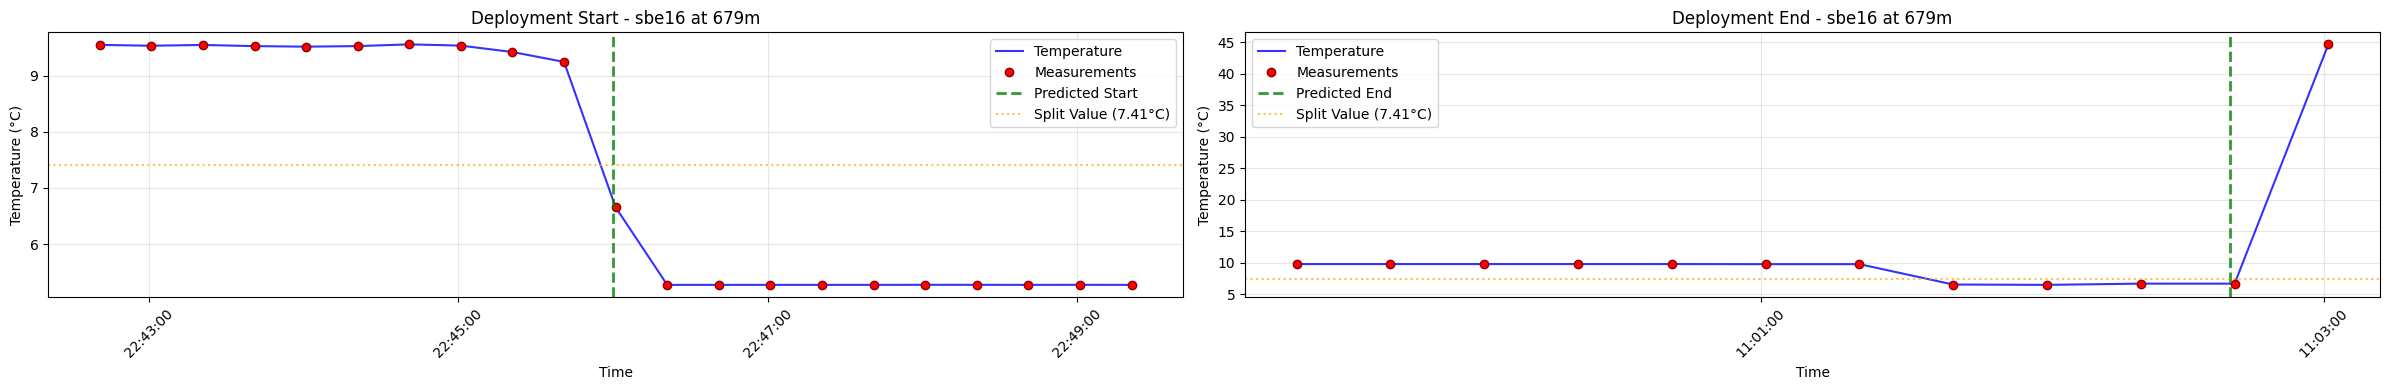

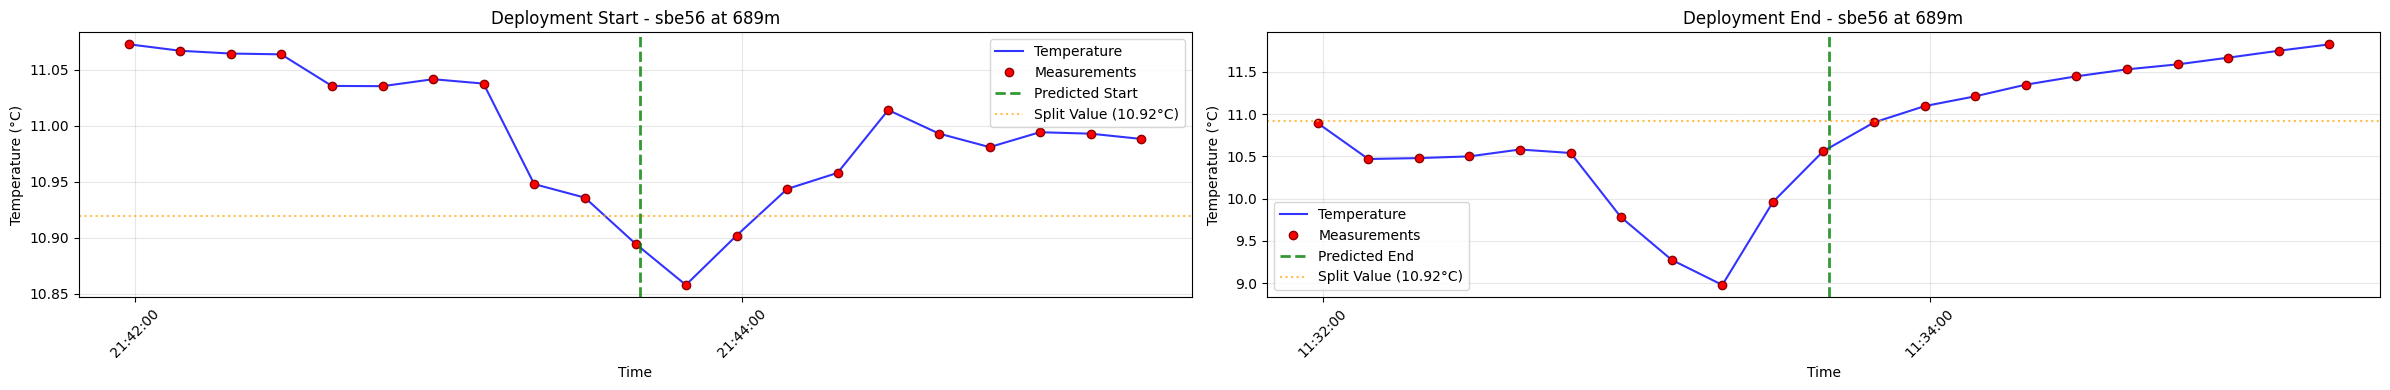

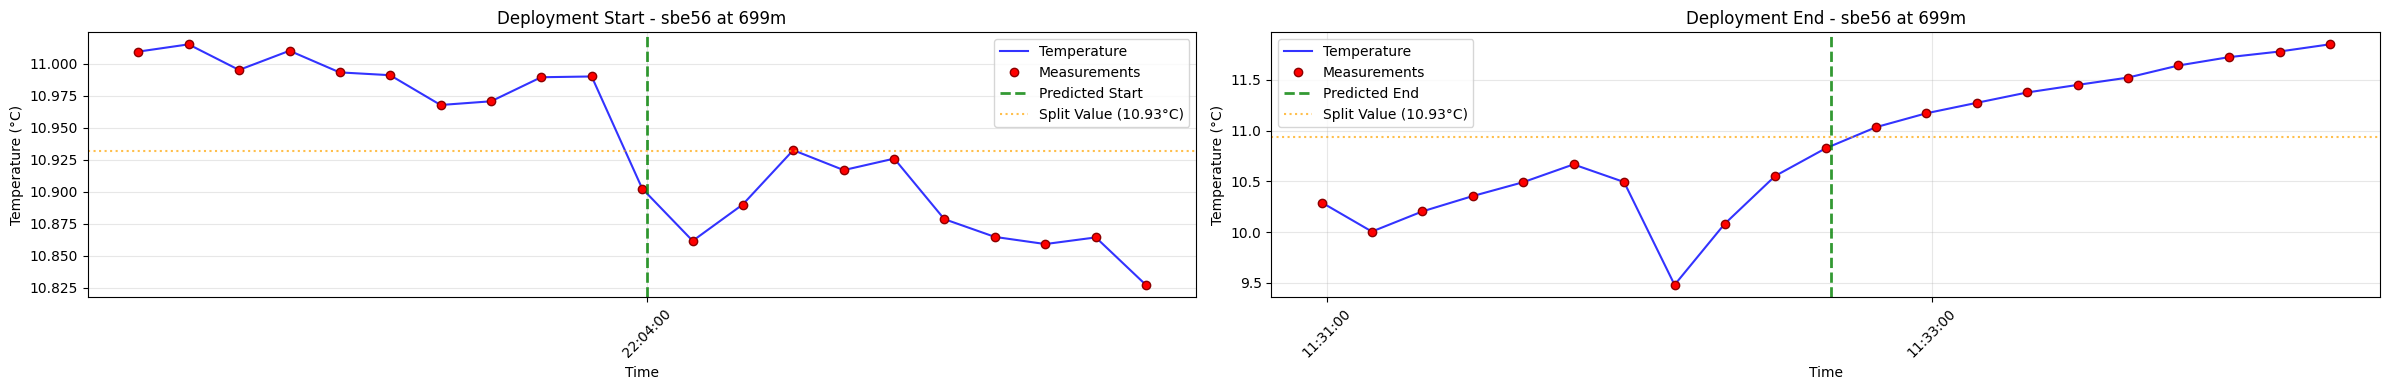

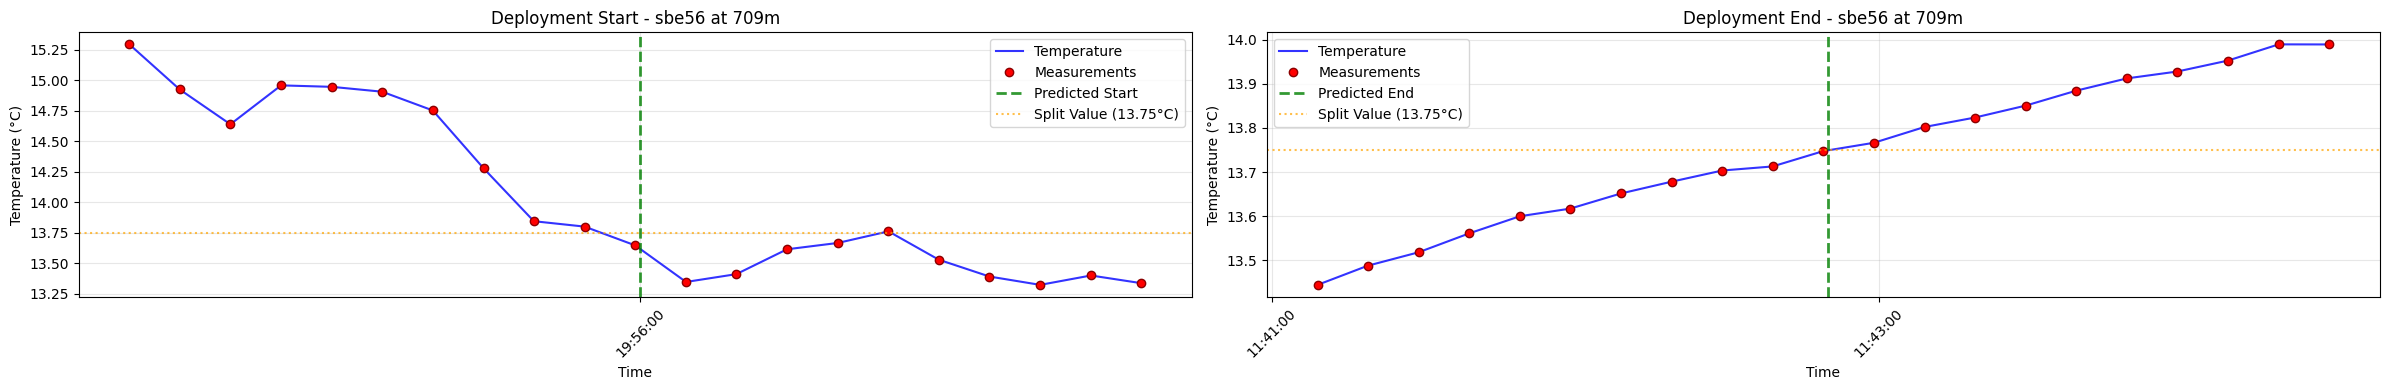

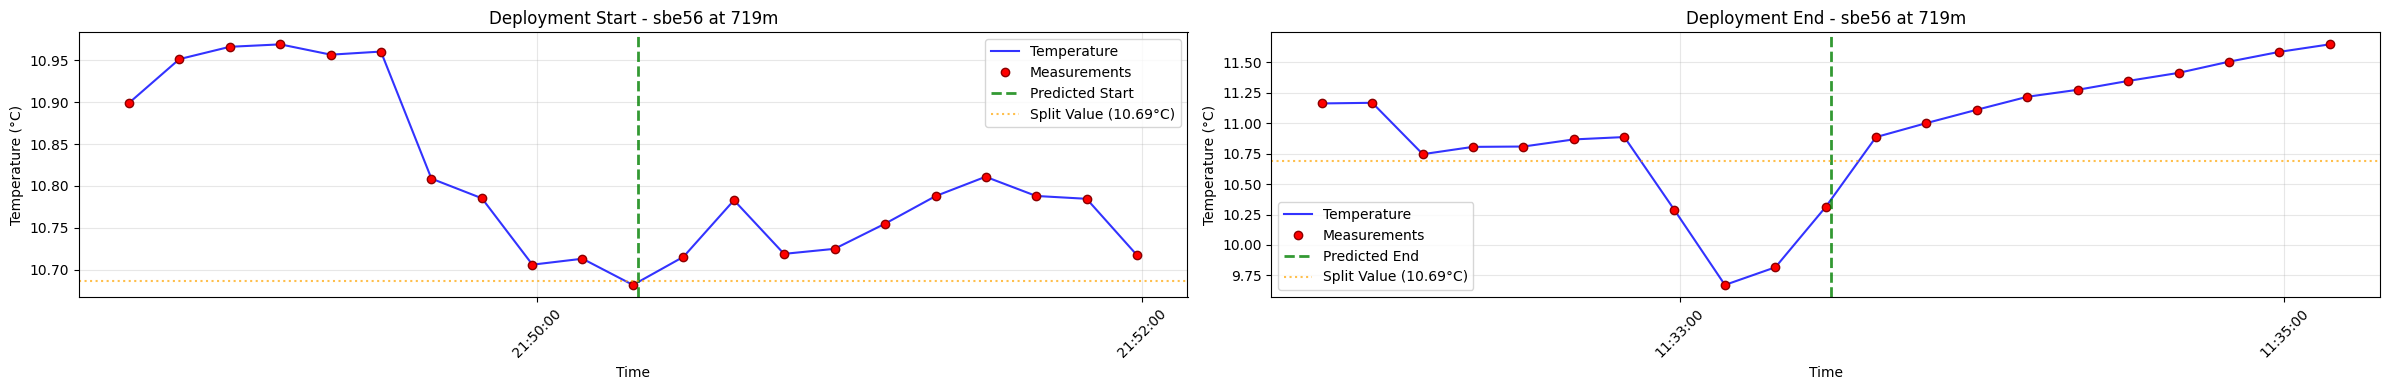

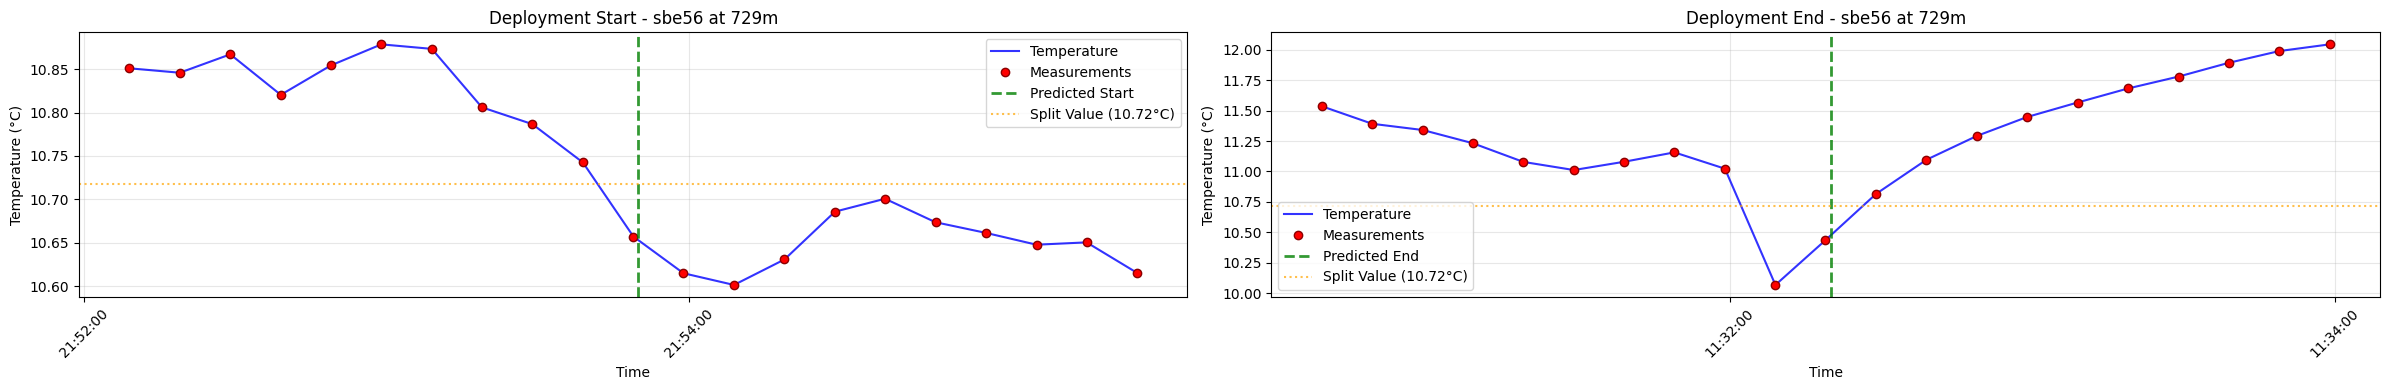

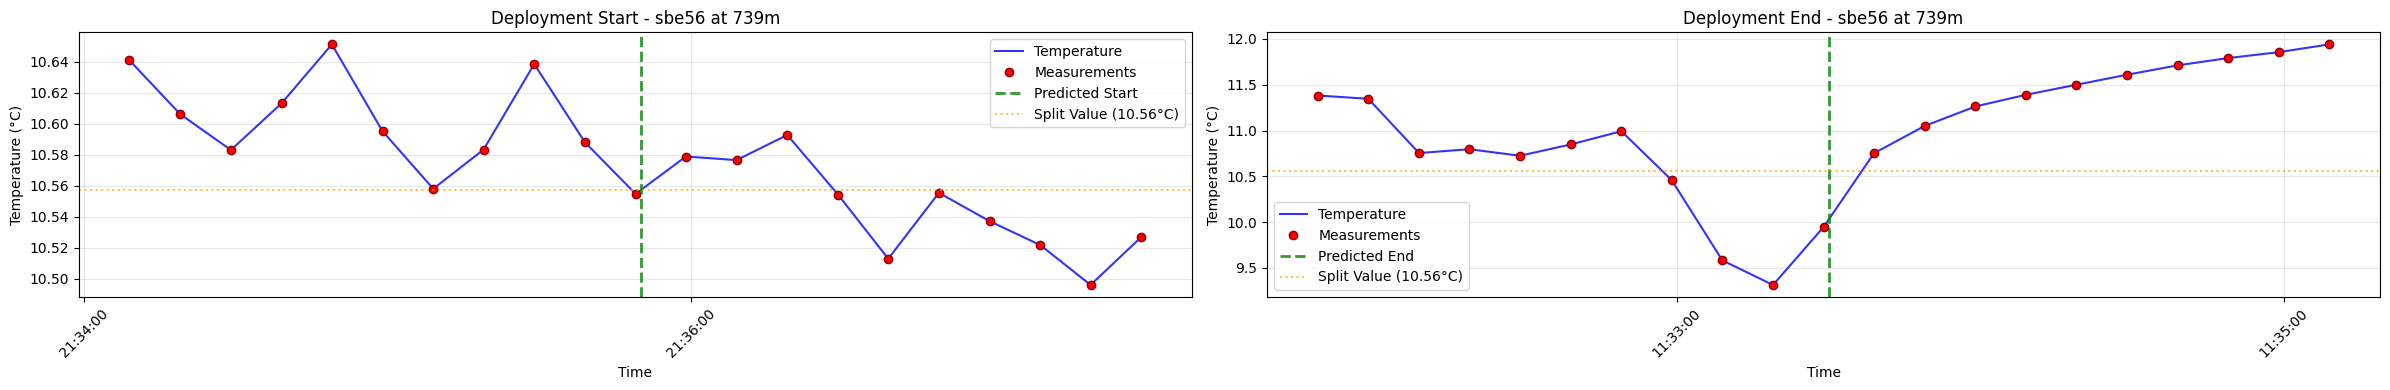

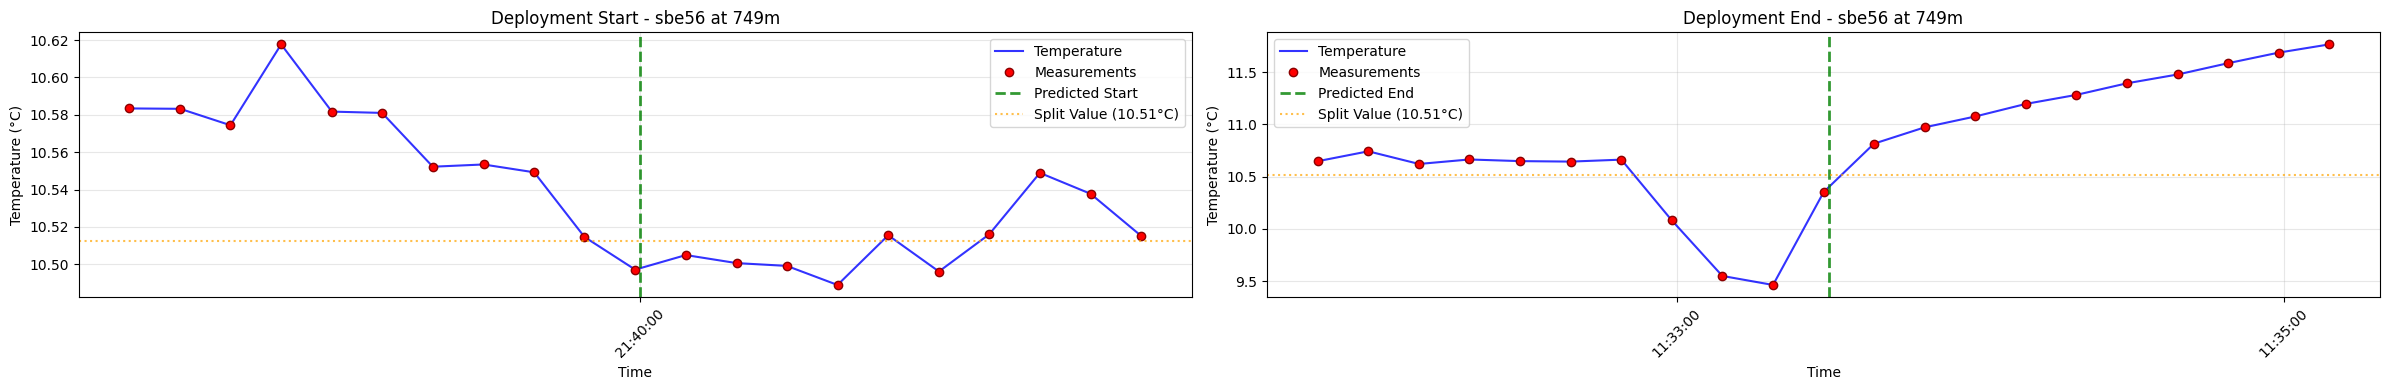

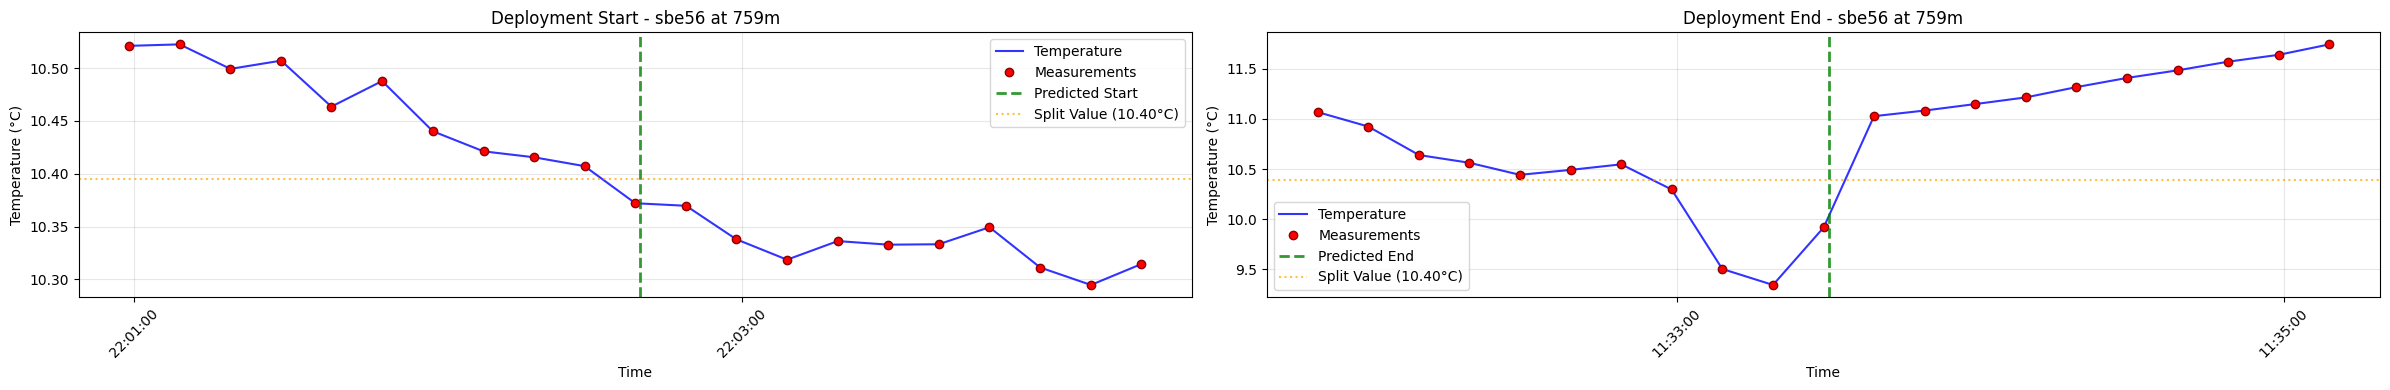

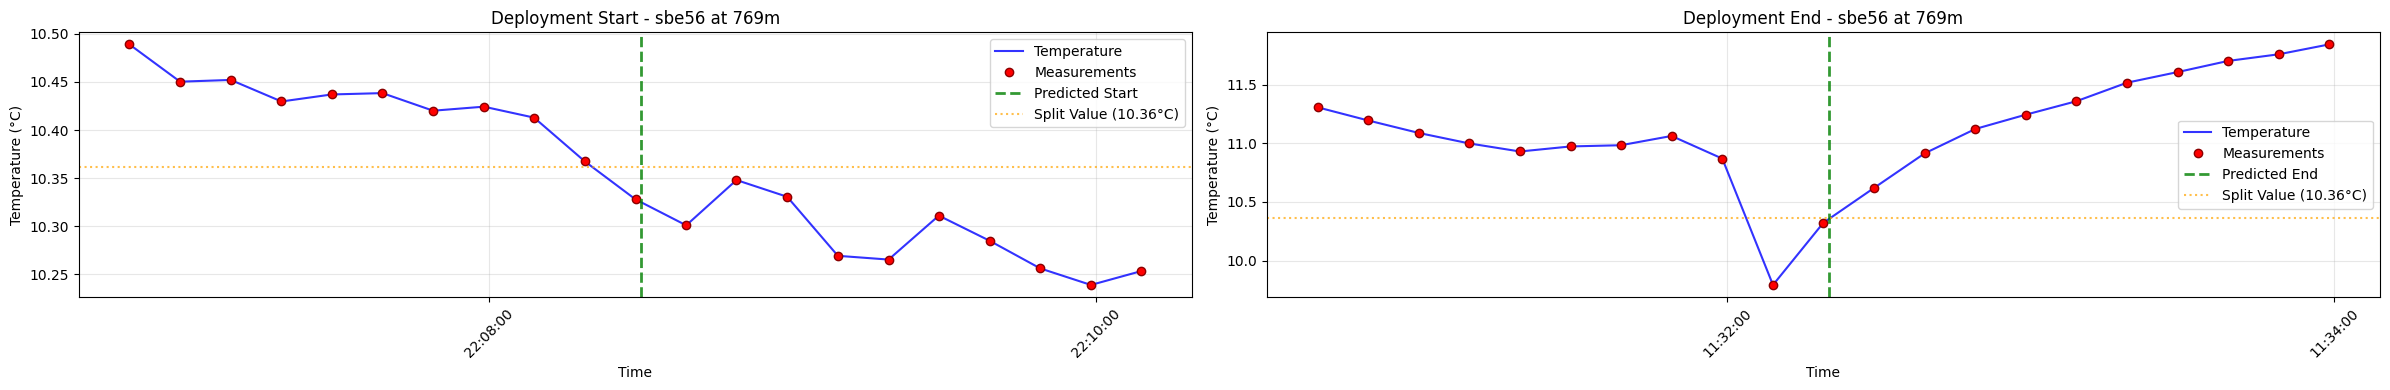

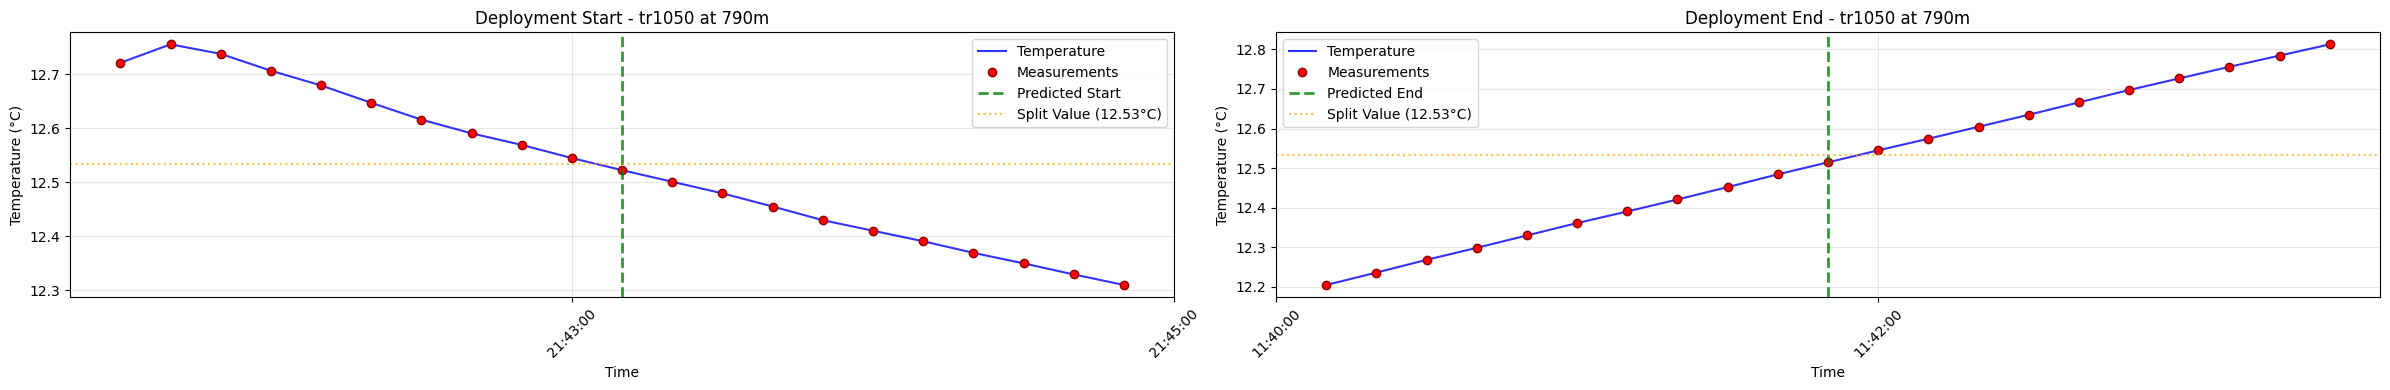

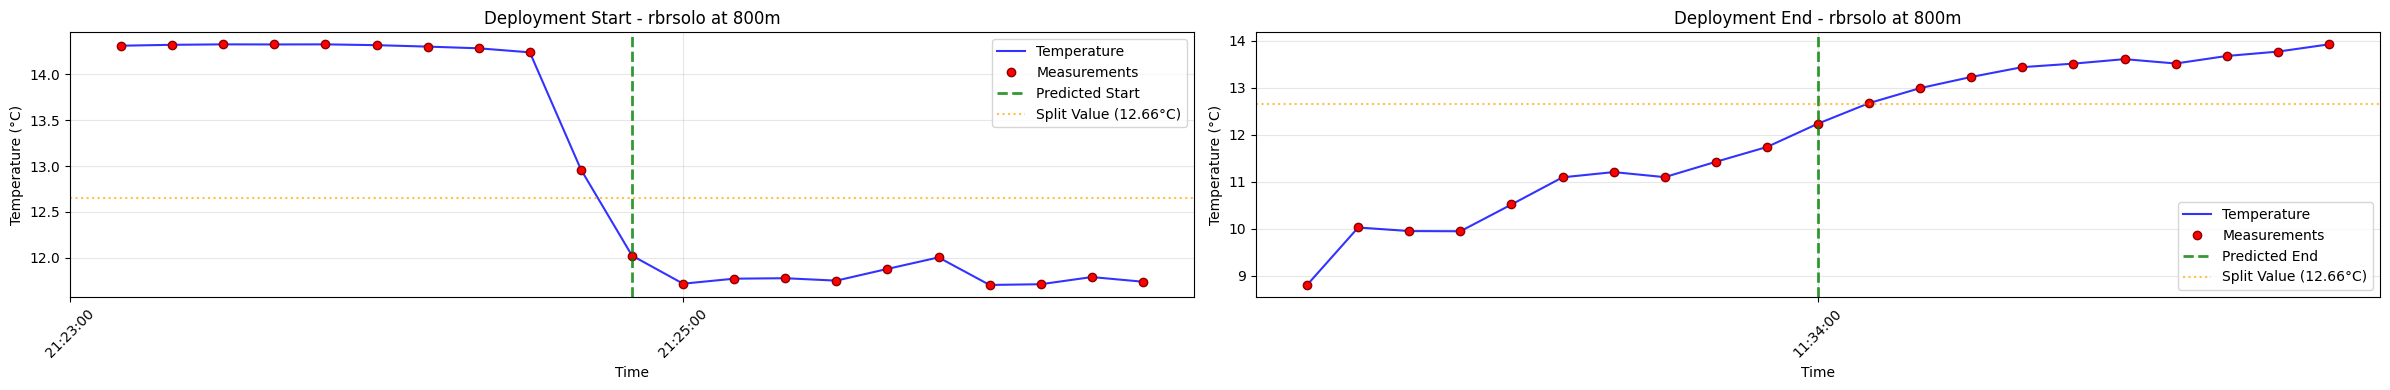

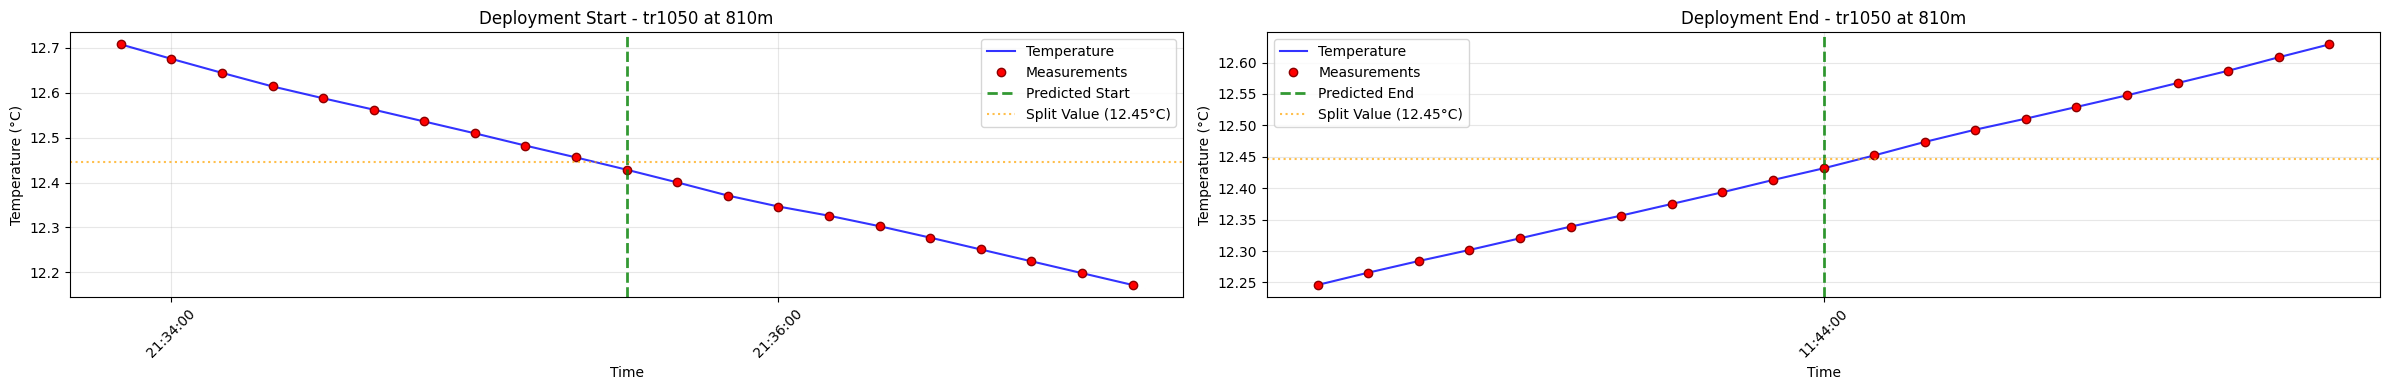

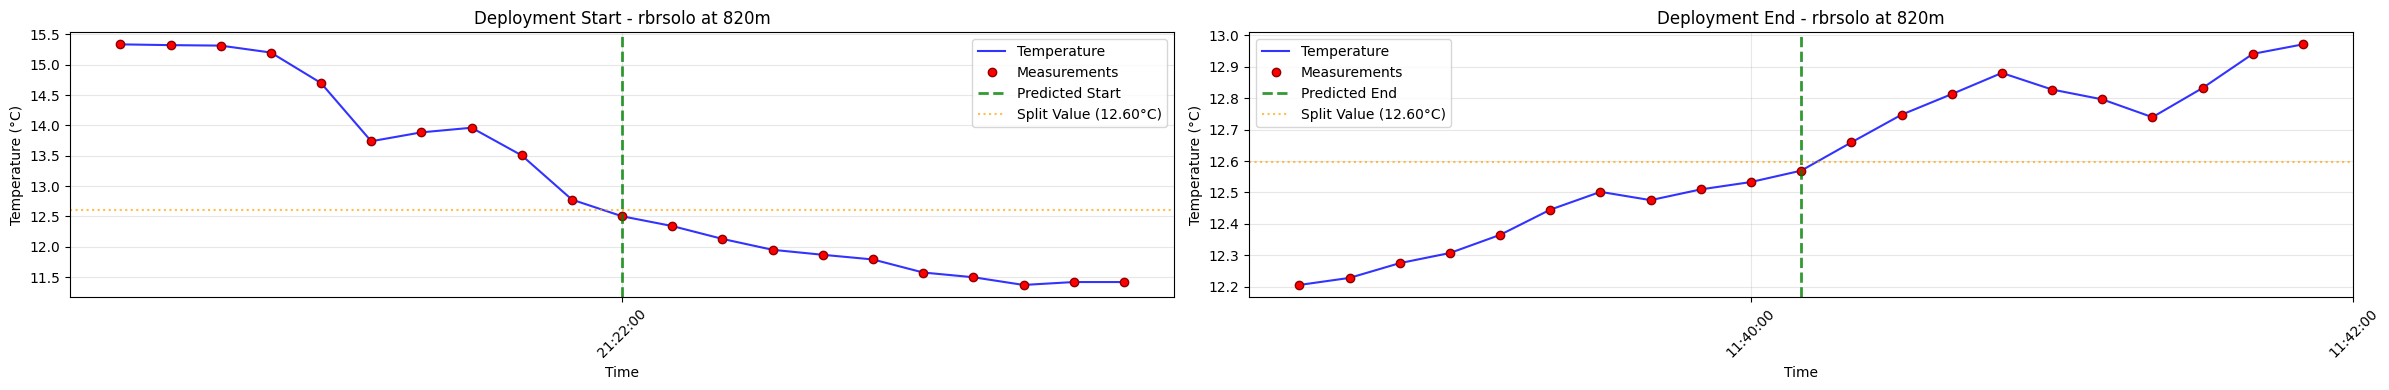

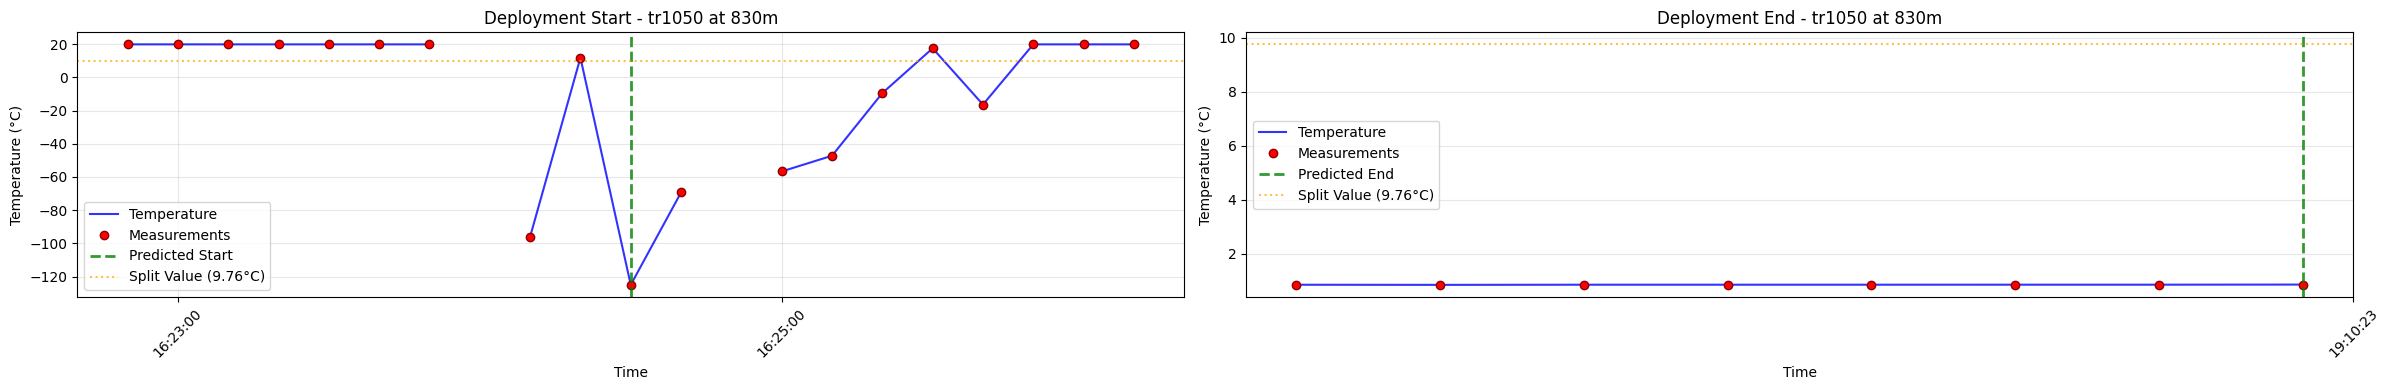

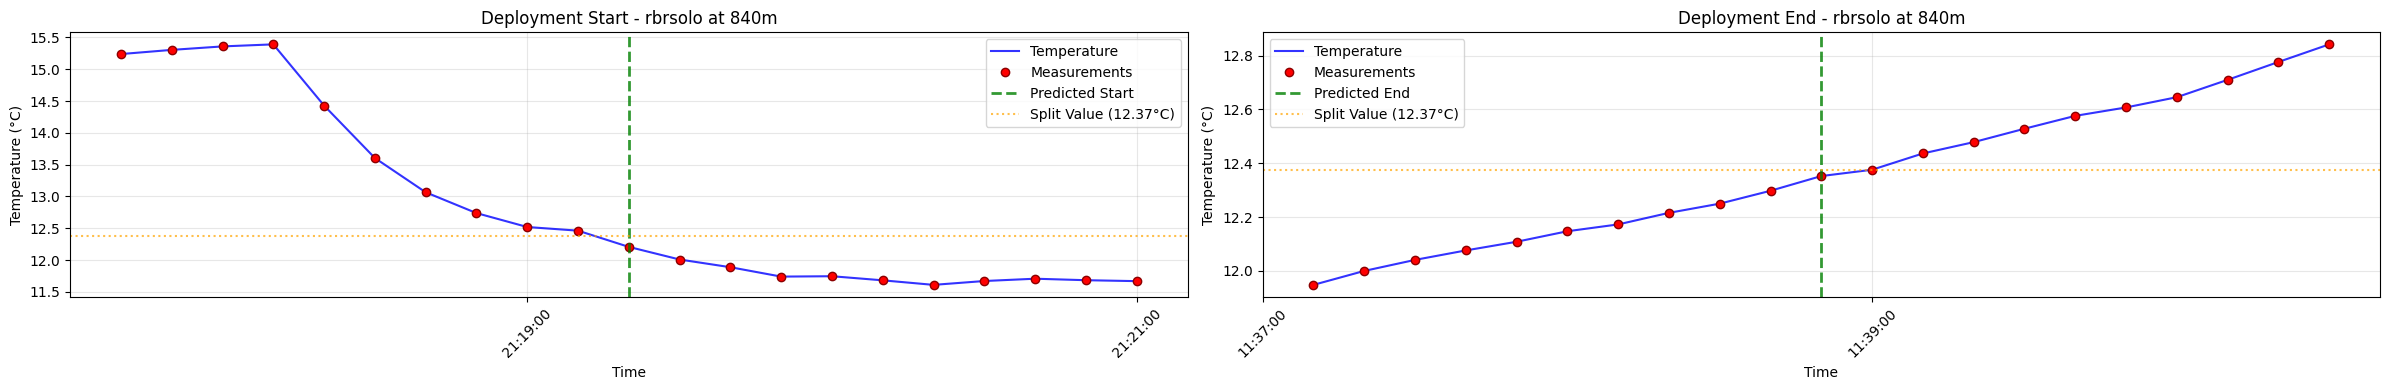

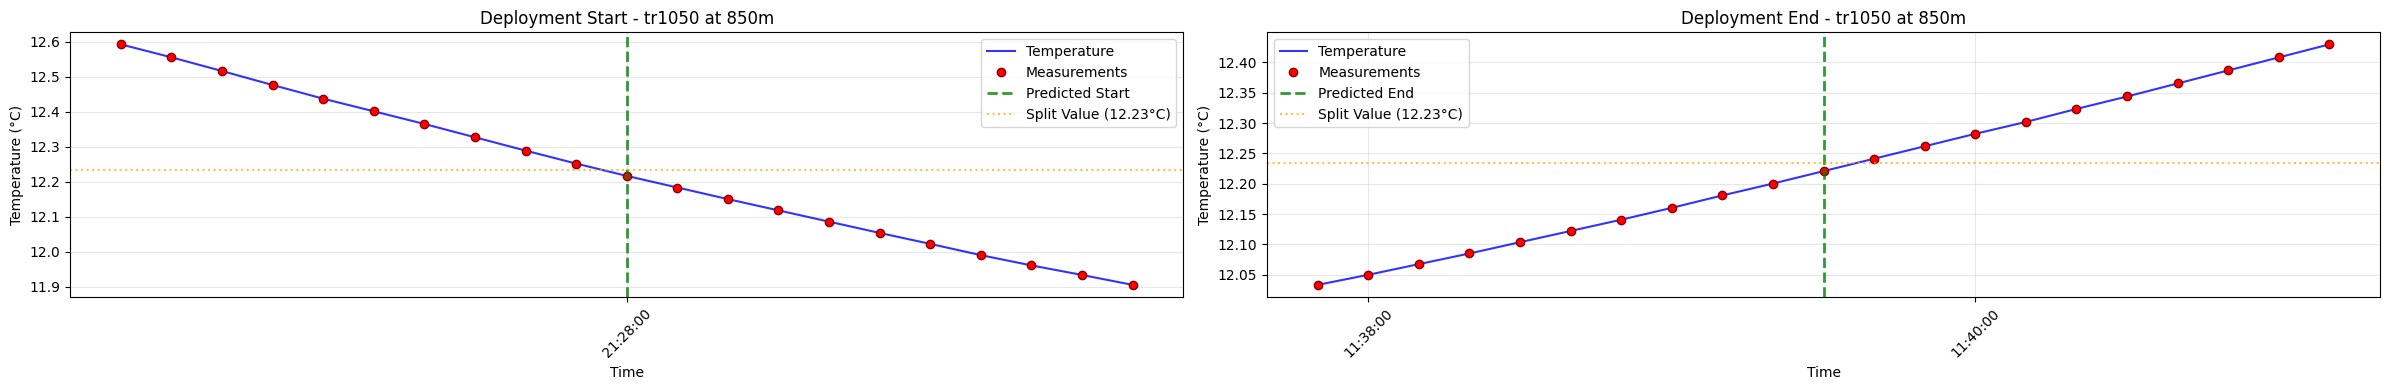

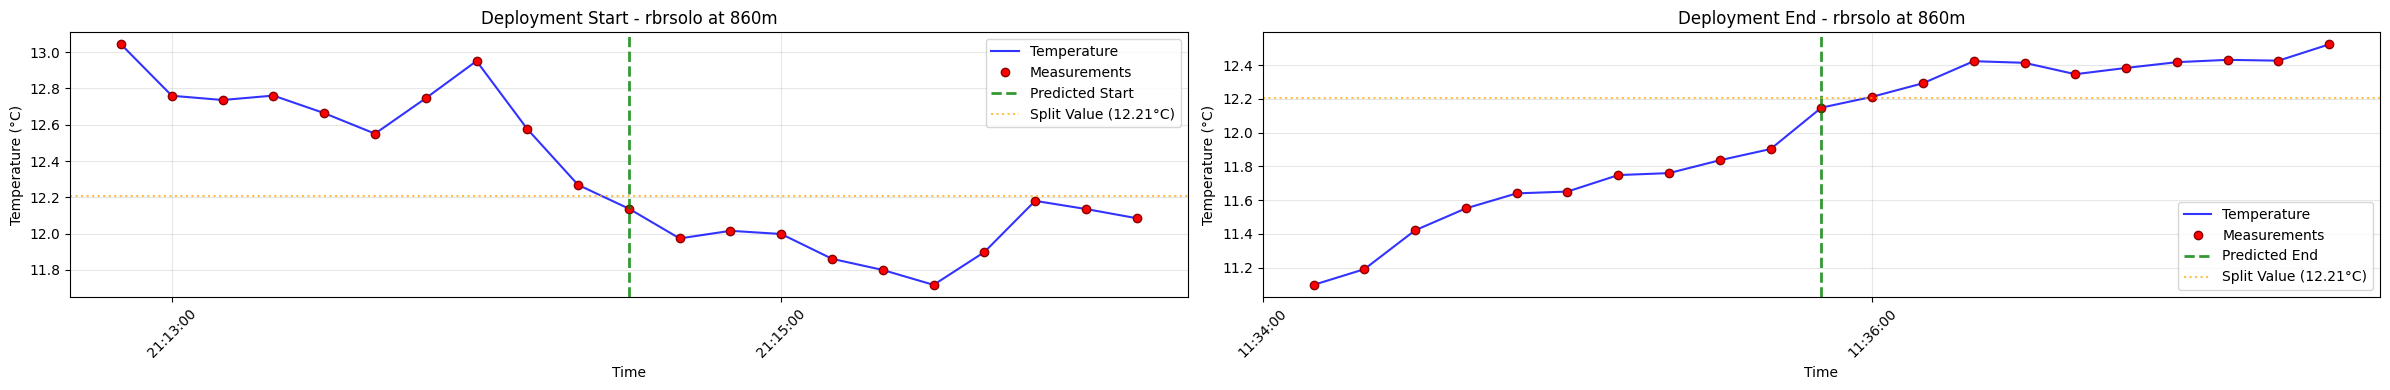

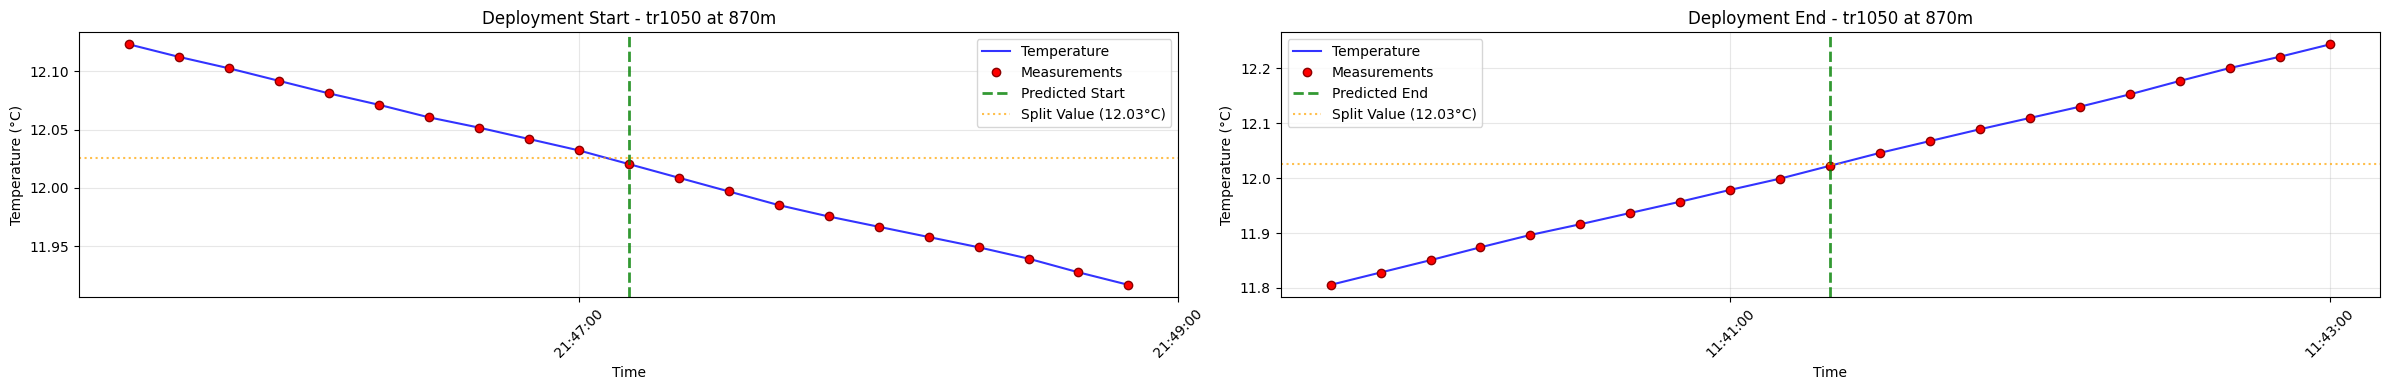

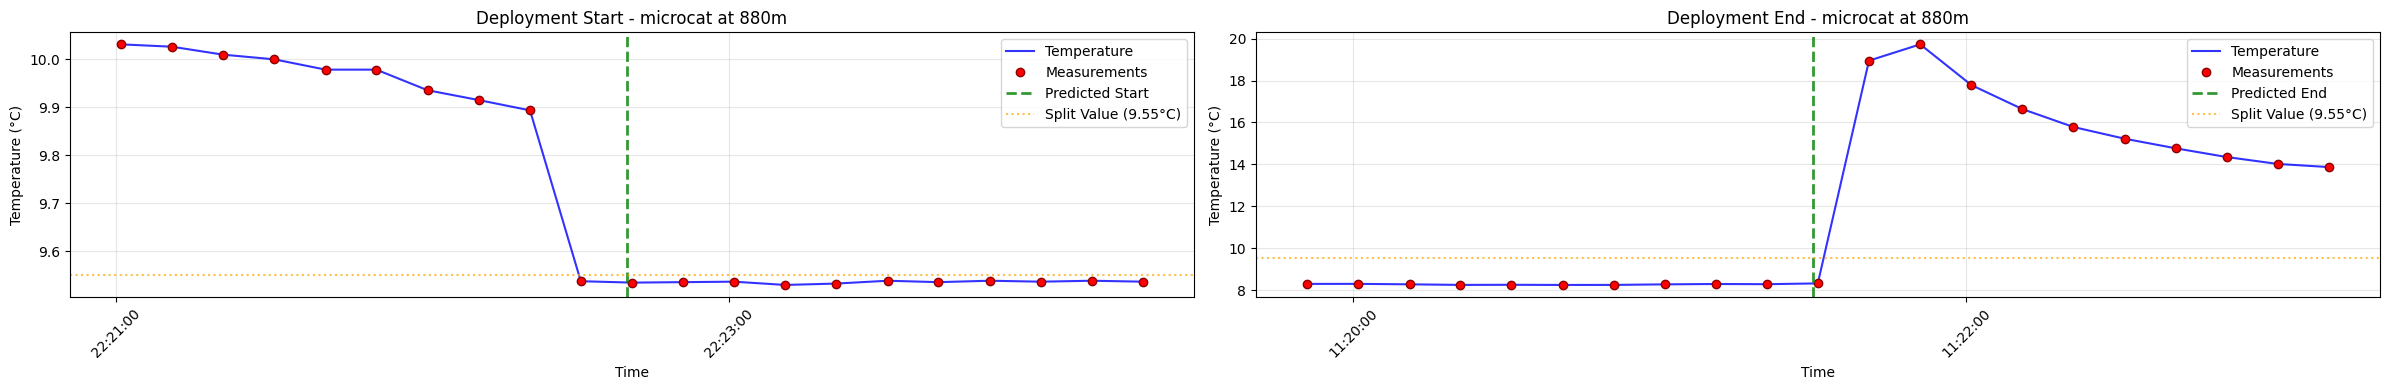

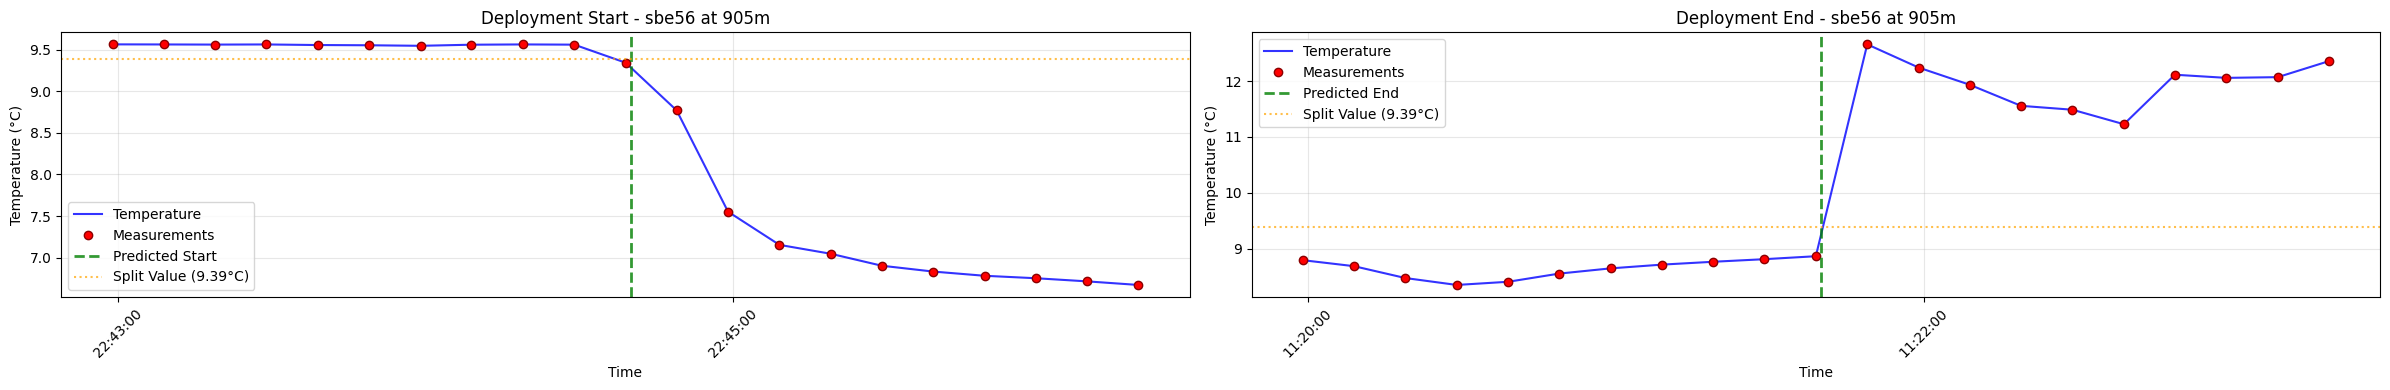

In [8]:
# Plot detailed deployment boundaries showing individual measurements
# This shows 10 samples before/after predicted boundaries with red circles and blue connecting lines
clock_offset.plot_deployment_boundaries(datasets, combined_ds, n_samples=10)

## Lag Correlation Analysis

In [9]:
# Get suggestion for best reference instrument (but you can override manually)
ref_suggestion = clock_offset.suggest_reference_instrument(combined_ds, offset_results)

# Use the suggested reference (or manually set ref_index to any value you prefer)
ref_index = ref_suggestion['suggested_index']  # You can change this manually
sub_sample = 5  # Subsampling factor for speed

print(f"Using reference instrument: Index {ref_index}")
print(f"Note: You can manually set ref_index to any instrument index (0-{combined_ds.sizes['N_LEVELS']-1})")
print()

correlation_results = clock_offset.perform_lag_correlation_analysis(
    combined_ds, ref_index=ref_index, sub_sample=sub_sample
)

# Print correlation summary
clock_offset.print_correlation_summary(combined_ds, correlation_results)

Suggested reference instrument for lag correlation:
  Index 15: tr1050 #13874 at 830m
  Average timing offset: +0.0s
  Reason: smallest absolute average timing offset

Using reference instrument: Index 15
Note: You can manually set ref_index to any instrument index (0-21)

Lag Correlation Analysis Results:
(Enter the summed value, no sign change, in the yaml as clock_offset)

Level 1 (#6363): max corr = 0.653 @lag -1726 --> clock_offset: -86300s
Level 2 (#2419): max corr = 0.526 @lag -2 --> clock_offset: -100s
Level 3 (#6401): max corr = 0.663 @lag -1726 --> clock_offset: -86300s
Level 4 (#6402): max corr = 0.663 @lag -1728 --> clock_offset: -86400s
Level 5 (#8482): max corr = 0.666 @lag -1699 --> clock_offset: -84950s
Level 6 (#6365): max corr = 0.667 @lag -1726 --> clock_offset: -86300s
Level 7 (#6409): max corr = 0.670 @lag -1730 --> clock_offset: -86500s
Level 8 (#6397): max corr = 0.672 @lag -1728 --> clock_offset: -86400s
Level 9 (#6366): max corr = 0.676 @lag -1728 --> clock_off

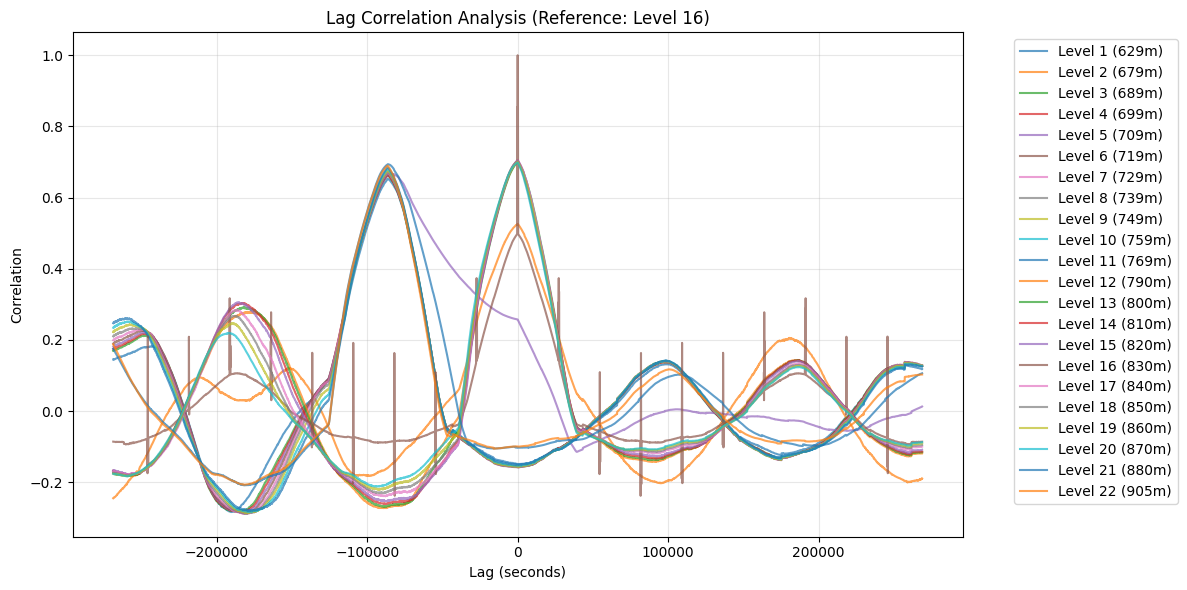

In [10]:
# Plot correlation results
time_interval = correlation_results['time_interval']
sub_sample = correlation_results['sub_sample']
depths = combined_ds['nominal_depth'].values

plt.figure(figsize=(12, 6))

max_lag_sub = len(correlation_results['correlations'][0]) // 2
lags_sub = np.arange(-max_lag_sub, max_lag_sub + 1)

for i, corrs in enumerate(correlation_results['correlations']):
    dt_sub = sub_sample * time_interval
    plt.plot(lags_sub * dt_sub, corrs,
             label=f'Level {i+1} ({depths[i]:.0f}m)', alpha=0.7)

plt.xlabel('Lag (seconds)')
plt.ylabel('Correlation')
plt.title(f'Lag Correlation Analysis (Reference: Level {ref_index+1})')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary: All Temperature Time Series

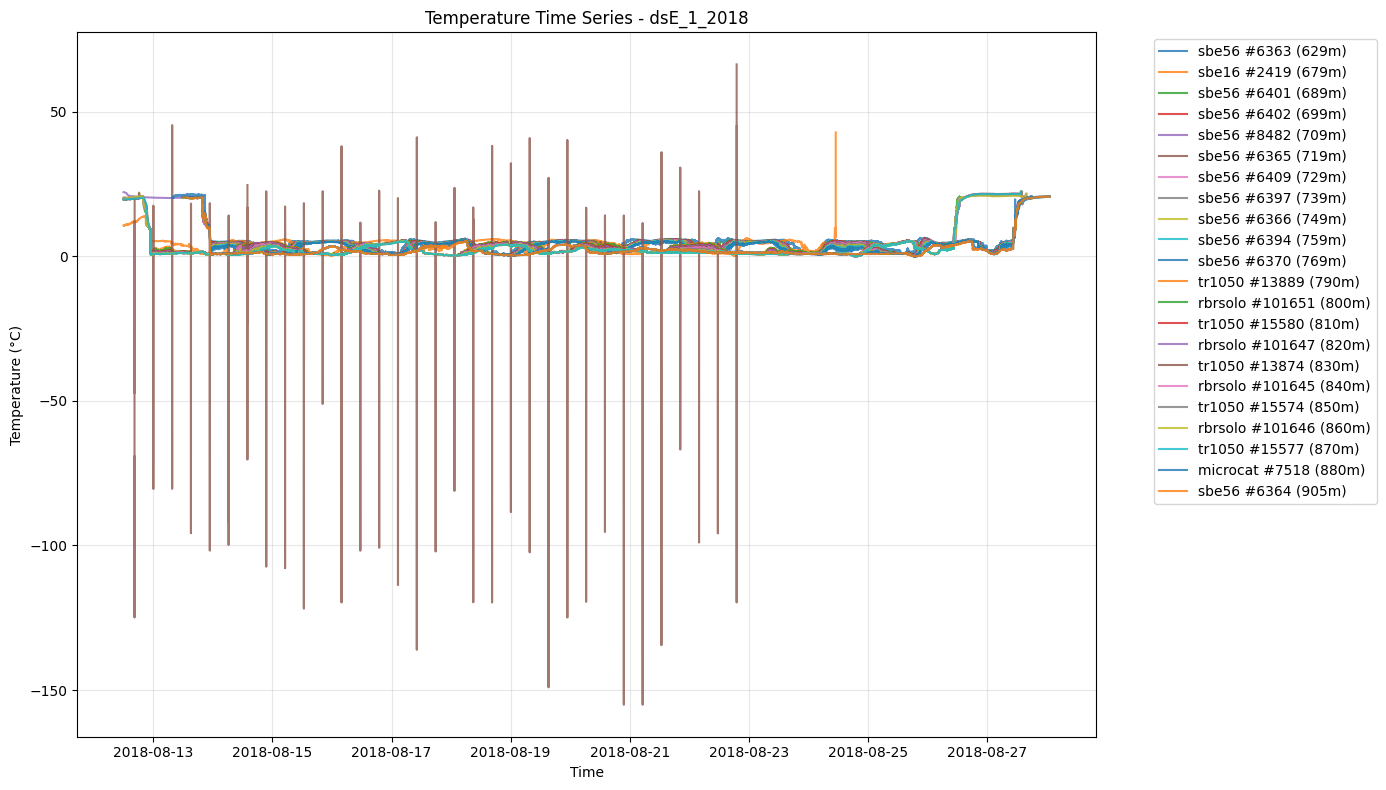

In [11]:
# Plot all temperature time series together
plt.figure(figsize=(14, 8))

for i in range(combined_ds.sizes['N_LEVELS']):
    depth = combined_ds['nominal_depth'][i].values
    instrument = combined_ds['instrument'][i].values
    serial = combined_ds['serial_number'][i].values

    plt.plot(combined_ds['time'], combined_ds['temperature'][:, i],
             label=f'{instrument} #{serial} ({depth:.0f}m)', alpha=0.8)

plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title(f'Temperature Time Series - {mooring_name}')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Recommendations

Based on the analysis above:

1. **Deployment Timing Analysis**: Shows offset estimates based on when instruments first/last detect "deep" water temperatures
2. **Lag Correlation Analysis**: Shows offset estimates based on cross-correlation of temperature time series

Use the **negative** of the calculated offset as the `clock_offset` value in the YAML file.

After updating the YAML file, run stage2 processing to apply the corrections, then re-run this analysis with `file_suffix = '_use'` to verify the corrections.